# Visión por Computador - Práctica 2 - Deep Learning en Computer Vision

#### 12 puntos   |   Fecha de entrega: 15 de Diciembre, 23:59   |   Forma de entrega: a través de la tarea creada en https://pradogrado2425.ugr.es/

### Estudiante: <mark>Eduardo Rodríguez Cao</mark>



# Instalación de librerías y funciones auxiliares.

<font color='blue'>El objetivo de esta práctica es aprender a diseñar, implementar, entrenar y utilizar (es decir, aplicar en inferencia) redes neuronales convolucionales en tareas de visión por computador (clasificación y regresión en imágenes) usando fastai (https://docs.fast.ai/).

<font color='blue'>Se proporciona una guía de ayuda (`Assignment_2_HG.ipynb`) para, entre otras cosas, saber cómo:
1. realizar funciones básicas de lectura de datos, entrenamiento y optimización;
2. crear gráficos para la evolución del error de clasificación en
los conjuntos de entrenamiento y validación;
3. y calcular el error de clasificación en el conjunto de prueba.

In [1]:
# The first thing we should do is to apply hardware acceleration via GPU. So, we have to go to Editar - Configuracion del Cuaderno - Acelerador por Hardware GPU

# Now we SET UP Fastai
!pip install -Uqq fastbook
!pip install nbdev
import fastbook
fastbook.setup_book()
import fastai
import fastcore
print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━

In [2]:
# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()



---



---



---



# <font color='blue'>**Ejercicio 1: BaseNet en CIFAR100 (3 puntos)**

<font color='blue'>**Dataset:**
En este ejercicio, trabajaremos con parte del conjunto de datos CIFAR100 (https://www.cs.toronto.edu/~kriz/cifar.html). Este conjunto de datos consta de $60000$ imágenes en color de $32\times32\times3$ (RGB) que representan 100 clases diferentes ($600$ imágenes por clase). Hay $50000$ imágenes para entrenamiento y $10000$ para test. No obstante, para el desarrollo del ejercicio solo consideraremos $25$ clases (de $100$). Por lo tanto, el conjunto de entrenamiento tendrá $12500$ imágenes y el conjunto de prueba $2500$ imágenes. Los alumnos deben emplear el $10\%$ del conjunto de entrenamiento para  validación.

<font color='blue'>**Modelo BaseNet:**
Comenzamos creando un modelo base llamado *BaseNet* que consta de dos bloques convolucionales (Conv+ReLU) separados por un proceso de *subsampling* (MaxPooling), y una cabeza compuesta por dos capas completamente conectadas (FC) (también llamadas capas densas). La arquitectura precisa se define en la siguiente tabla:

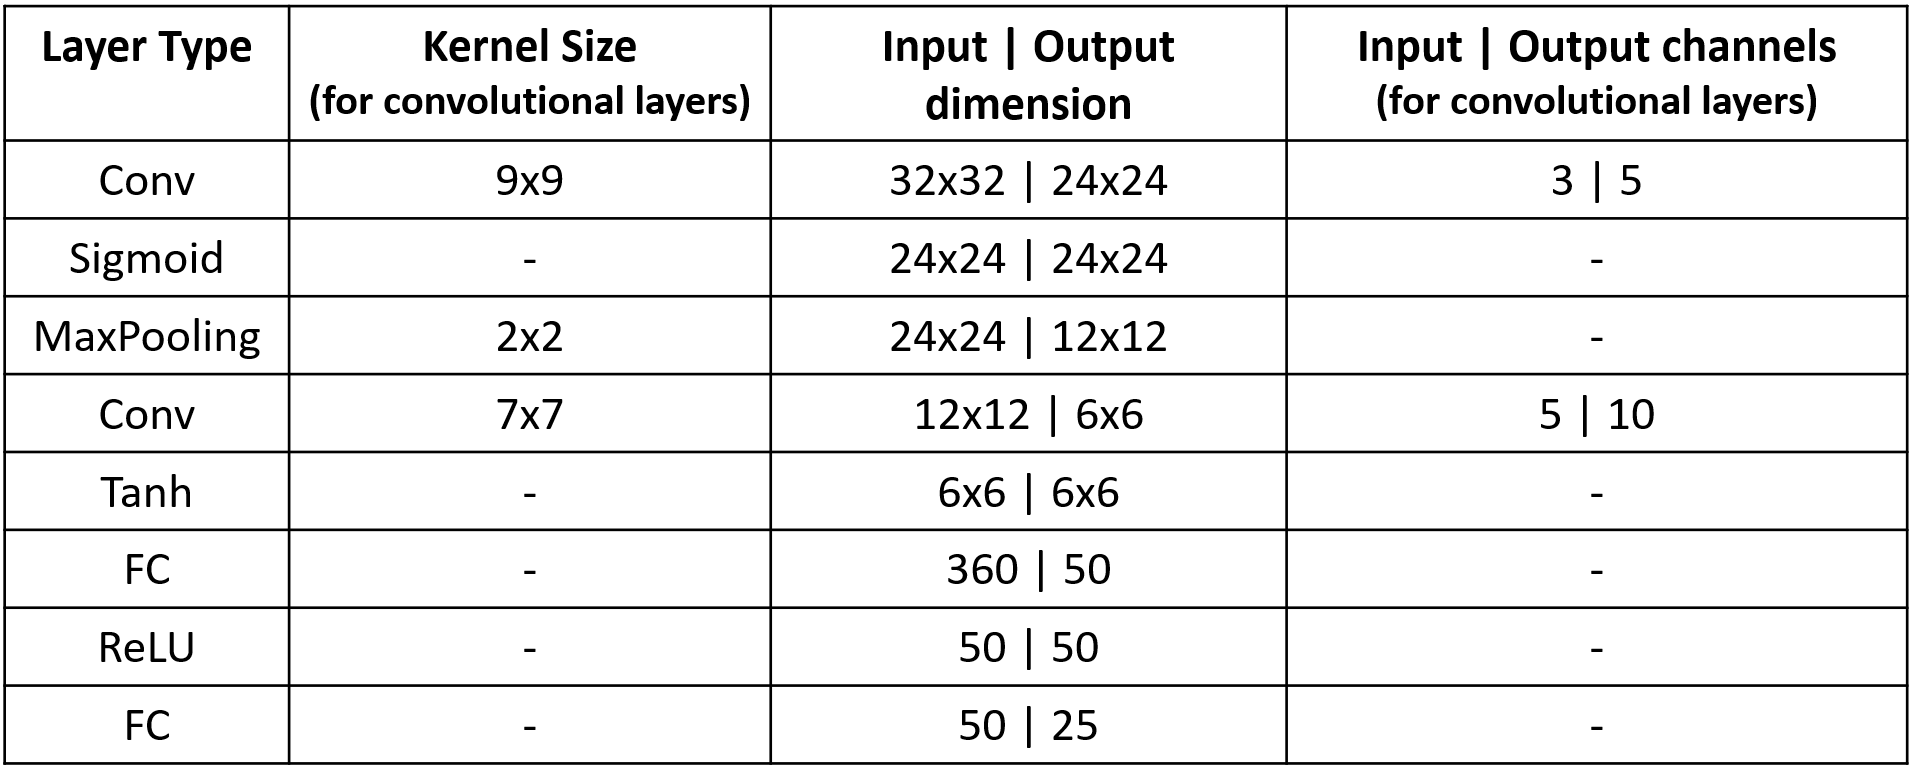

<font color='blue'>Los alumnos deben:
1. Crear el código para el modelo *BaseNet* empleando la librería fastai.
2. Explicar y describir cada una de las capas de la arquitectura *BaseNet*, así como las decisiones de implementación tomadas. Por ejemplo, ¿qué función de pérdida se debería emplear: `CrossEntropyLoss()`, `CrossEntropyLossFlat()` o alguna otra? ¿Se debería incorporar manualmente, en la definición de la red, la función de activación de la capa final (`nn.Softmax()`)? ¿Por qué?
3. Desglosar detalladamente el número de parámetros de esta arquitectura, y cuánto contribuye cada capa a dicho número total. Se debe hacer un `summary()` del modelo para verificar que la arquitectura se ha construido adecuadamente y que el número de parámetros es correcto (es decir, se corresponde con lo esperado).
4. Entrenar el modelo con _Adam_ (incluyendo _early stopping_ con una paciencia de $5$ durante $25$ épocas) y evaluar su rendimiento. En dicha evaluación se debe emplear/mostrar/analizar: la matriz de confusión en entrenamiento, validación y test; la _accuracy_ en entrenamiento, validación y test; y la evolución, por épocas de entrenamiento, tanto de la función de pérdida (en entrenamiento y validación) como de la _accuracy_ (en validación) y el _F1 score (weighted)_ (en validación).



## <font color='blue'> **1.1 Descarga y lectura de datos, creación de conjuntos de entrenamiento y test.**

In [3]:
# We get the CIFAR100 dataset
path = untar_data(URLs.CIFAR_100,force_download=True)

In [4]:
# The CIFAR_100 dataset, as well as the MNIST dataset, follows a common layout for machine learning datasets:
# separate folders for the training set and the validation set (and/or test set).
# Let's see what's inside both the training and test sets
print(path)
print(path.ls())
print((path/'train').ls())
print((path/'test').ls())
train_classes = (path/'train').ls()
test_classes = (path/'test').ls()
print(len(train_classes))

/root/.fastai/data/cifar100
[Path('/root/.fastai/data/cifar100/train'), Path('/root/.fastai/data/cifar100/test')]
[Path('/root/.fastai/data/cifar100/train/insects'), Path('/root/.fastai/data/cifar100/train/reptiles'), Path('/root/.fastai/data/cifar100/train/people'), Path('/root/.fastai/data/cifar100/train/aquatic_mammals'), Path('/root/.fastai/data/cifar100/train/medium_mammals'), Path('/root/.fastai/data/cifar100/train/large_man-made_outdoor_things'), Path('/root/.fastai/data/cifar100/train/fruit_and_vegetables'), Path('/root/.fastai/data/cifar100/train/food_containers'), Path('/root/.fastai/data/cifar100/train/small_mammals'), Path('/root/.fastai/data/cifar100/train/household_electrical_devices'), Path('/root/.fastai/data/cifar100/train/large_natural_outdoor_scenes'), Path('/root/.fastai/data/cifar100/train/household_furniture'), Path('/root/.fastai/data/cifar100/train/non-insect_invertebrates'), Path('/root/.fastai/data/cifar100/train/fish'), Path('/root/.fastai/data/cifar100/train

Vemos que hay 20 clases, pero eso no debe confundirnos. Eso son solo las 20 superclases en que está subdividido el dataset. Véase https://github.com/fastai/dlcert2/blob/master/docs/datasets.md:
"This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. **The 100 classes in the CIFAR-100 are grouped into 20 superclasses**. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs)."

In [5]:
# Queremos verificar que dentro de cada una de las 20 superclases hay 5 clases,
# lo que da las 100 clases que hay. También queremos verificar que el número de imágenes
# es correcto
print('Clases dentro de la primera superclase (',train_classes[0],'): ', train_classes[0].ls())
for i in range(20):
  print('Número de clases dentro de superclase ',i,': ', len(train_classes[i].ls()))
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

Clases dentro de la primera superclase ( /root/.fastai/data/cifar100/train/insects ):  [Path('/root/.fastai/data/cifar100/train/insects/cockroach'), Path('/root/.fastai/data/cifar100/train/insects/beetle'), Path('/root/.fastai/data/cifar100/train/insects/bee'), Path('/root/.fastai/data/cifar100/train/insects/butterfly'), Path('/root/.fastai/data/cifar100/train/insects/caterpillar')]
Número de clases dentro de superclase  0 :  5
Número de clases dentro de superclase  1 :  5
Número de clases dentro de superclase  2 :  5
Número de clases dentro de superclase  3 :  5
Número de clases dentro de superclase  4 :  5
Número de clases dentro de superclase  5 :  5
Número de clases dentro de superclase  6 :  5
Número de clases dentro de superclase  7 :  5
Número de clases dentro de superclase  8 :  5
Número de clases dentro de superclase  9 :  5
Número de clases dentro de superclase  10 :  5
Número de clases dentro de superclase  11 :  5
Número de clases dentro de superclase  12 :  5
Número de cla

Ahora nos quedamos con las primeras 25 clases. Lo que hacemos es eliminar las 75 últimas del dataset.

In [6]:
#https://stackoverflow.com/questions/185936/how-to-delete-the-contents-of-a-folder
import shutil
number_of_classes_to_keep = 25
number_of_superclasses_to_keep = int(number_of_classes_to_keep/5)
print('SUPERCLASES ELIMINADAS:')
for i in range(number_of_superclasses_to_keep,len(train_classes)):
  print(train_classes[i])
  shutil.rmtree(train_classes[i])
print('SUPERCLASES CONSERVADAS:')
for i in range(number_of_superclasses_to_keep):
  print(train_classes[i])

SUPERCLASES ELIMINADAS:
/root/.fastai/data/cifar100/train/large_man-made_outdoor_things
/root/.fastai/data/cifar100/train/fruit_and_vegetables
/root/.fastai/data/cifar100/train/food_containers
/root/.fastai/data/cifar100/train/small_mammals
/root/.fastai/data/cifar100/train/household_electrical_devices
/root/.fastai/data/cifar100/train/large_natural_outdoor_scenes
/root/.fastai/data/cifar100/train/household_furniture
/root/.fastai/data/cifar100/train/non-insect_invertebrates
/root/.fastai/data/cifar100/train/fish
/root/.fastai/data/cifar100/train/vehicles_2
/root/.fastai/data/cifar100/train/vehicles_1
/root/.fastai/data/cifar100/train/flowers
/root/.fastai/data/cifar100/train/large_carnivores
/root/.fastai/data/cifar100/train/large_omnivores_and_herbivores
/root/.fastai/data/cifar100/train/trees
SUPERCLASES CONSERVADAS:
/root/.fastai/data/cifar100/train/insects
/root/.fastai/data/cifar100/train/reptiles
/root/.fastai/data/cifar100/train/people
/root/.fastai/data/cifar100/train/aquatic_

In [7]:
# También eliminamos las clases en test
for i in range(number_of_superclasses_to_keep,len(test_classes)):
  print(test_classes[i])
  shutil.rmtree(test_classes[i])

/root/.fastai/data/cifar100/test/large_man-made_outdoor_things
/root/.fastai/data/cifar100/test/fruit_and_vegetables
/root/.fastai/data/cifar100/test/food_containers
/root/.fastai/data/cifar100/test/small_mammals
/root/.fastai/data/cifar100/test/household_electrical_devices
/root/.fastai/data/cifar100/test/large_natural_outdoor_scenes
/root/.fastai/data/cifar100/test/household_furniture
/root/.fastai/data/cifar100/test/non-insect_invertebrates
/root/.fastai/data/cifar100/test/fish
/root/.fastai/data/cifar100/test/vehicles_2
/root/.fastai/data/cifar100/test/vehicles_1
/root/.fastai/data/cifar100/test/flowers
/root/.fastai/data/cifar100/test/large_carnivores
/root/.fastai/data/cifar100/test/large_omnivores_and_herbivores
/root/.fastai/data/cifar100/test/trees


Ahora intentamos verificar si los hemos eliminado realmente.

In [8]:
print(path)
train_classes = (path/'train').ls()
test_classes = (path/'test').ls()
print(len(train_classes))
print(len(test_classes))

/root/.fastai/data/cifar100
5
5


Y que el número de ejemplos en training y test es el correcto.

In [9]:
print('Clases dentro de la primera superclase (',train_classes[0],'): ', train_classes[0].ls())
files_train = get_image_files(path/'train')
files_test = get_image_files(path/'test')
print('Total training images: ', len(files_train))
print('Total test images: ', len(files_test))

Clases dentro de la primera superclase ( /root/.fastai/data/cifar100/train/insects ):  [Path('/root/.fastai/data/cifar100/train/insects/cockroach'), Path('/root/.fastai/data/cifar100/train/insects/beetle'), Path('/root/.fastai/data/cifar100/train/insects/bee'), Path('/root/.fastai/data/cifar100/train/insects/butterfly'), Path('/root/.fastai/data/cifar100/train/insects/caterpillar')]
Total training images:  12500
Total test images:  2500


Podemos observar que ahora tenemos el dataset tal y como nos interesa, con 12500 imágenes de entrenamiento y 2500 de test.

## <font color='blue'> **1.2 DataBlock y DataLoaders.**

Ahora vamos a proceder a cargar los datos de entrenamiento. Para ello hacemos uso de DataLoaders y DataBlock. En `fastai`, `DataBlock` y `DataLoaders` son herramientas esenciales para la gestión y carga de datos en Deep Learning.

`DataBlock` actúa como una receta que define cómo se tienen que cargar, dividir en conjuntos y etiquetar los datos. Nos permite describir cómo queremos que se haga este preprocesamiento de datos para no tener que hacerlo a mano. Los parámetros principales son:
*   `blocks`: Define los tipos de datos de entrada y salida del modelo en un par `(entrada, salida)`. En nuestro caso ponemos `(ImageBlock, CategoryBlock)` ya que tenemos imágenes de entrada y etiquetas categóricas de salida (clases). Si fuera un problema de regresión podríamos poner `RegressionBlock`, y si quisieramos clasificación multietiqueta `MultiCategoryBlock`. En nuestro problema queremos usar el dataset `CIFAR100` para clasificar con una etiqueta, así que usamos `CategoryBlock`.
*   `get_items`: Función que obtiene los elementos del dataset, en nuestro caso `get_image_files` para extraer las imágenes de las subcarpetas de forma recursiva (ya que las imágenes están en las carpetas de sus respectivas clases que a su vez están dentro de las carpetas de las superclases).
*   `splitter`: Función que divide los datos en conjuntos de entrenamiento y validación. En nuestro caso usamos `RandomSplitter`, que es la opción más simple, con un $10\%$ de los datos en validación (`valid_pct = 0.1`) y una semilla fijada para mantener reproducibilidad(`seed = 42`). Aunque la división no es estratificada, en general con suficientes datos es poco probable que alguna clase no esté suficientemente representada en alguno de los conjuntos.
*   `get_y`: Función que obtiene las etiquetas para los ejemplos del dataset. Nosotros usamos `parent_label` que obtiene la etiqueta del nombre de la carpeta padre, que es la carpeta de la clase en nuestro caso.
*   `item_tfms`: Transformaciones aplicadas a cada elemento antes del batching, como por ejemplo redimensionado de imágenes. Nosotros no hacemos nada ya que las imágenes tienen las mismas dimensiones y además concuerdan con las dimensiones de entrada de nuestro modelo `BaseNet`, que son $32 \times 32 \times 3$.
*    `batch_tfms`: Transformaciones aplicadas a cada batch de datos, como por ejemplo data augmentation. En este ejercicio tenemos un modelo base que después mejoraremos, no hacemos nada por ahora.

`dataloaders` es un método de `DataBlock` que crea un objeto que facilita la carga de datos en batches durante el entrenamiento del modelo, se construye a partir del `DataBlock`. No solo simplifica el trabajo con batches sino que además permite iterar eficientemenete sobre los datos y aplicar lo definido en el `DataBlock`. Los parámetros principales son:

*   `source`: Fuente de los datos, en nuestro caso la ruta al directorio de entrenamiento `path/'train'`.
*   `bs`: Tamaño del batch, en nuestro caso $32$ es un tamaño por defecto que experimentalmente se sabe que funciona relativamente bien.
*   `shuffle`: Flag para mezclar los datos cada epoch. Por defecto es `True` y lo dejamos así ya que así nos aseguramos de que el modelo no se ajusta a un orden específico de los datos y generaliza mejor.

Finalmente calculamos cuántas imágenes tenemos en entrenamiento y validación y visualizamos un batch.






Numero de ejemplos de entrenamiento (una vez descartados los de validacion): 11250
Numero de ejemplos de validacion: 1250


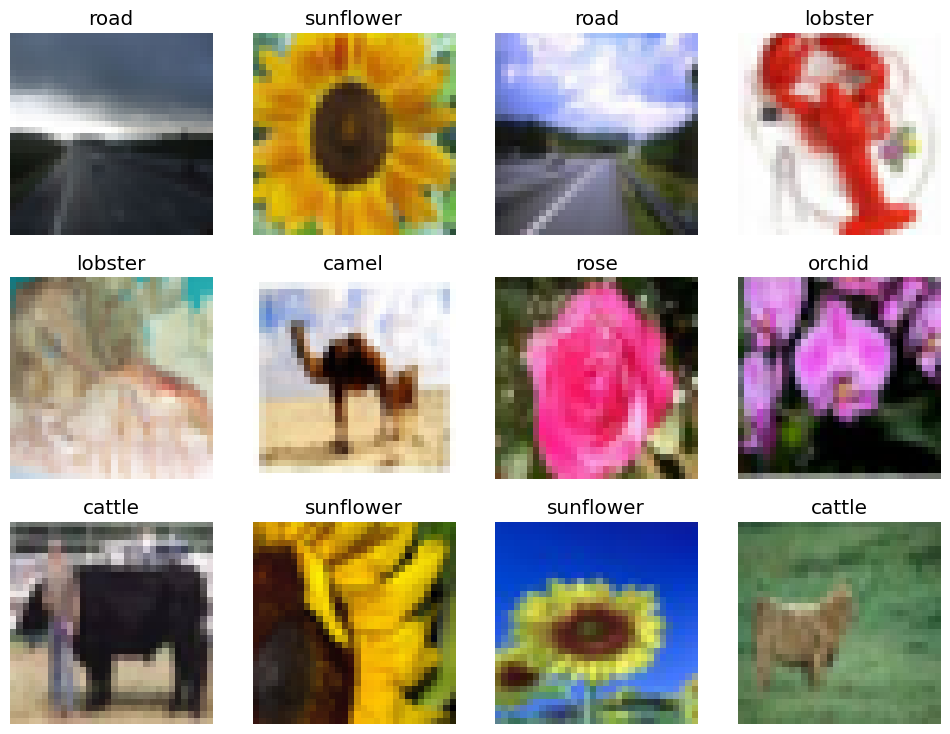

In [ ]:
# Datablock
db = DataBlock(
  blocks    = (ImageBlock, CategoryBlock),                  # Tipos de datos de entrada y salida
  get_items = get_image_files,                              # Extraer imágenes
  splitter  = RandomSplitter(valid_pct = 0.1, seed = 42),   # Entrenamiento y validación (90%/10%)
  get_y     = parent_label                                  # Etiquetas
)

# Dataloader del conjunto de entrenamiento
dls = db.dataloaders(path/'train', bs = 32)
# Imprimir un batch, con no más de 12 ejemplos
dls.show_batch(max_n=12)

print('Numero de ejemplos de entrenamiento (una vez descartados los de validacion):', len(dls.train_ds))
print('Numero de ejemplos de validacion:', len(dls.valid_ds))

Ahora mostramos un batch del conjunto de entrenamiento con un máximo de $12$ imágenes mostradas en $2$ filas.

Example of training data


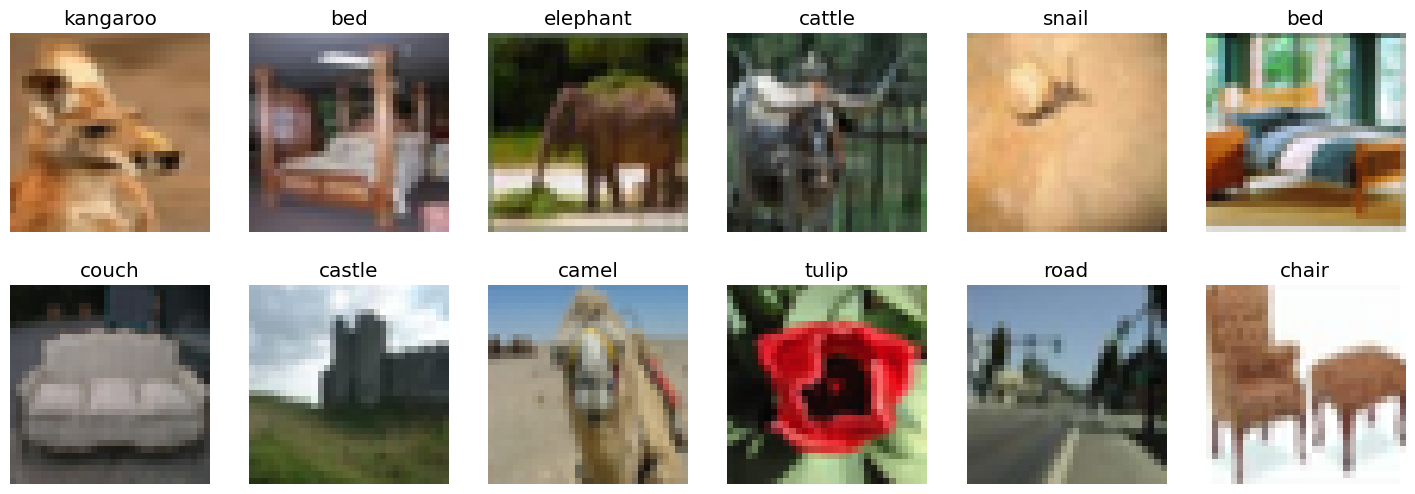

In [ ]:
print('Example of training data')
dls.train.show_batch(max_n=12, nrows=2)

Y un batch del conjunto de validación.

Example of validation data


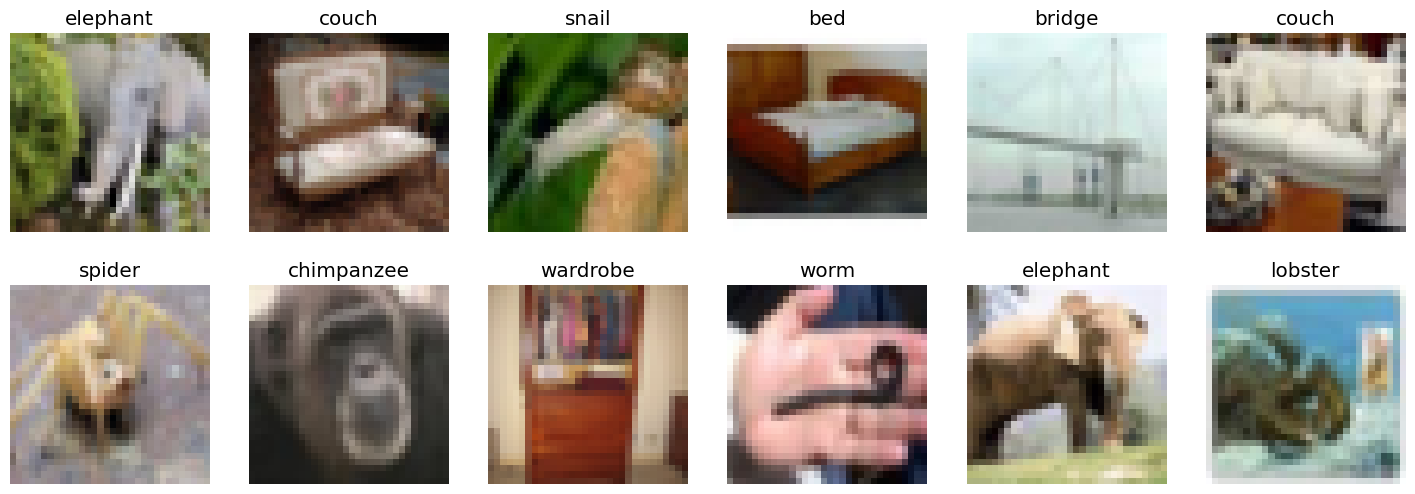

In [ ]:
print('Example of validation data')
dls.valid.show_batch(max_n=12, nrows=2)


## <font color='blue'> **1.3 Definición del modelo *BaseNet* empleando la librería fastai.**


<font color='blue'> 1. Crear el código para el modelo *BaseNet* empleando la librería fastai.


Creamos el modelo y el `Learner`, en el siguiente apartado explicamos el código y la teoría subyacente.

In [ ]:
# BaseNet
BaseNet = sequential(
    nn.Conv2d(in_channels = 3, out_channels = 5, kernel_size = (9,9)),  # Capa 1: Convolución
    nn.Sigmoid(),                                                       # Capa 2: Sigmoide
    nn.MaxPool2d(kernel_size = (2,2)),                                  # Capa 3: MaxPooling2D
    nn.Conv2d(in_channels = 5, out_channels = 10, kernel_size = (7,7)), # Capa 4: Convolución
    nn.Tanh(),                                                          # Capa 5: Tanh
    nn.Flatten(),                                                       # Capa 6: Flatten
    nn.Linear(in_features = 360, out_features = 50),                    # Capa 7: Fully-Connected
    nn.ReLU(),                                                          # Capa 8: ReLU
    nn.Linear(in_features = 50, out_features = 25)                      # Capa 9: Fully-Connected
    # nn.Softmax()
)

BaseNet

Sequential(
  (0): Conv2d(3, 5, kernel_size=(9, 9), stride=(1, 1))
  (1): Sigmoid()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(5, 10, kernel_size=(7, 7), stride=(1, 1))
  (4): Tanh()
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=360, out_features=50, bias=True)
  (7): ReLU()
  (8): Linear(in_features=50, out_features=25, bias=True)
)

In [ ]:
# Learner
learn = Learner(dls, BaseNet, loss_func = CrossEntropyLossFlat(), metrics = [accuracy, F1Score(average='weighted')])

<font color='blue'> 2. Explicar y describir cada una de las capas de la arquitectura *BaseNet*, así como las decisiones de implementación tomadas. Por ejemplo, ¿qué función de pérdida se debería emplear: `CrossEntropyLoss()`, `CrossEntropyLossFlat()` o alguna otra? ¿Se debería incorporar manualmente, en la definición de la red, la función de activación de la capa final (`nn.Softmax()`)? ¿Por qué?

Para definir el modelo usamos `sequential` que nos permite definir una red neuronal lineal, es decir tal que la salida de cada capa se convierte en la entrada de la capa siguiente. También usamos el módulo `nn`(Neural Network) de PyTorch para definir las capas. Veamos las capas que tenemos en detalle:


*   `Conv2D`: capa de convolución de una CNN(Convolutional Neural Network). Esta capa extrae características espaciales de las imágenes tal y como se ha estudiado en teoría: tenemos un kernel de dimensiones $\mathrm{kernelsize}\times \mathrm{inchannels}$, tal que se hacen convoluciones sobre la imagen entera, con todos sus canales a la vez. Esto produce una imagen con un solo canal, y en función de cuántos canales de salida tengamos, este proceso se repite el mismo número de veces, cada vez con un kernel distinto. En la primera capa de este tipo tenemos el número de canales de entrada `in_channels=3` y salida `out_channels=5`con el tamaño del kernel `kernel_size=(9,9)`. Como no los especificamos, el paso es por defecto $1$ y no hay padding. Por lo tanto tenemos que una imagen $32\times32$ se reduce con un kernel $9\times9$ a una imagen $24\times24$, ya que el kernel quita 4 pixeles por cada lado (arriba, abajo, izquierda, derecha).
En la segunda capa de este tipo tenemos `in_channels=5` ya que las capas anteriores no cambian el número de canales establecido por la primera capa convolucional, `out_channels=10` y `kernel_size=(7,7)`, de modo que la imagen $12\times12$ se reduce a $6\times6$.
*   `MaxPool2d`: capa de agrupación máxima cuyo propósito principal es reducir dimensionalidad conservando las características más importantes. En esta capa operamos en regiones locales de la imagen de entrada, calculando el máximo en una ventana de tamaño fijo. Este valor sustituye la ventana, de modo que conseguimos reducir la dimensionalidad en función de su tamaño. Esta operación se hace en cada canal por separado, de modo que no se altera el número de canales, solo las dimensiones de altura y anchura. En nuestro caso tenemos `kernel_size=(2,2)` con `stride=(2,2)`, valor por defecto que es el mismo que el tamaño del kernel (para que no se solapen las ventanas), y ningún padding. De esta forma la imagen de entrada $24\times24$ queda reducida a $12\times12$.
*   `Flatten`: capa simple que convierte una matriz tridimensional en un vector unidimensional, "aplanandolo" para que el resultado pueda ser procesado por capas densas que vienen a continuación. En nuestro caso, tenemos $6 \times 6 \times 10$ de salida de la capa anterior, luego el `flatten` devuelve $360$.
*   `Linear`: capa densa (fully-connected) formada por neuronas, de modo que cada neurona recibe toda la entrada. En cada neurona se hace producto escalar del vector de pesos con el vector entrada y se le suma un bias, cuyo propósito es permitir que la función de activación (en la siguiente capa) se pueda trasladar en el eje $X$ (por ejemplo, en la sigmoide podríamos no tener $\sigma(0)=1/2$ siempre, algo que nos puede ser útil para que la función de activación represente un rango de valores más amplio). Matemáticamente: $a\cdot w^t + b$, donde $a$ es el vector de entrada, $w^t$ el vector de pesos traspuesto (para hacer producto escalar), y $b$ es el bias. La FC en sí se suele utilizar al final de la red neuronal para aprender las características extraídas de las imágenes por capas convolucionales anteriores, forzar la dimensión de la salida de la red y realizar clasificación. En nuestro caso la última capa FC tiene $25$ neuronas en la salida, cada una representa la clase que queremos predecir. La neurona con una predicción más alta es la clase predecida por la red.
*   `Sigmoid`, `Tanh`, `ReLU`: funciones de activación que se pueden visualizar en la siguiente celda, donde aparecen sus respectivas definiciones. Su propósito es introductir no linealidad en el modelo, de forma que este pueda aprender relaciones complicadas. Sin estas el modelo sería lineal, independientemente de su profundidad (cabe mencionar que ReLU es lineal a trozos, pero no es lineal, cosa que puede resultar confusa). Además las funciones de activación restringen el rango de los valores de salida, lo cual ayuda estabilizar los gradientes durante backpropagation. También son diferenciables, lo cual es esencial para el gradiente descendente (ReLU realmente no es diferenciable en todo el dominio, ya que en $0$ no lo es, pero se suele aproximar la derivada por $0$ o $1$ sin gran impacto en la optimización). Las funciones `Sigmoid` y `Tanh` se parecen bastante y ambas sufren del problema de los gradientes desvanecentes, ya que para entradas muy grandes vemos que las funciones se aplanan, lo cual produce gradientes muy cercanos a $0$ y se ralentiza el entrenamiento. `ReLU`(Rectified Linear Unit) no tiene este problema, aunque tiene el de los ReLUs que se mueren, donde las neuronas no se activan nunca más tras tener $0$ como salida. En general, `ReLU` es la función más popular, existe una variante `LeakyReLU` que resuelve el problema de neuronas muertas introduciendo gradientes negativos (en vez de $0$ constante en el semieje negativo tenemos una recta), además `ReLU` es computacionalmente muy eficiente. En general se intenta evitar el uso de `Sigmoid` y `Tanh` para capas ocultas, debido al problema de los gradientes.
*   `SoftMax`: función de activación que se suele usar en la capa de salida de redes neuronales, sobre todo en problemas de clasificación multiclase. Toma un vector de reales y devuelve una distribución de probabilidad, asignando probabilidades a cada clase del problema. Matemáticamente: $$\sigma: \mathbb {R}^K \longrightarrow [0,1]^ K
\,\,\,\, \sigma (x)_i = \frac{e^{x_i}}{\sum_{j=1}^K e^{x_j}},$$
Claramente es diferenciable, que como ya hemos dicho es una propiedad que necesitamos.



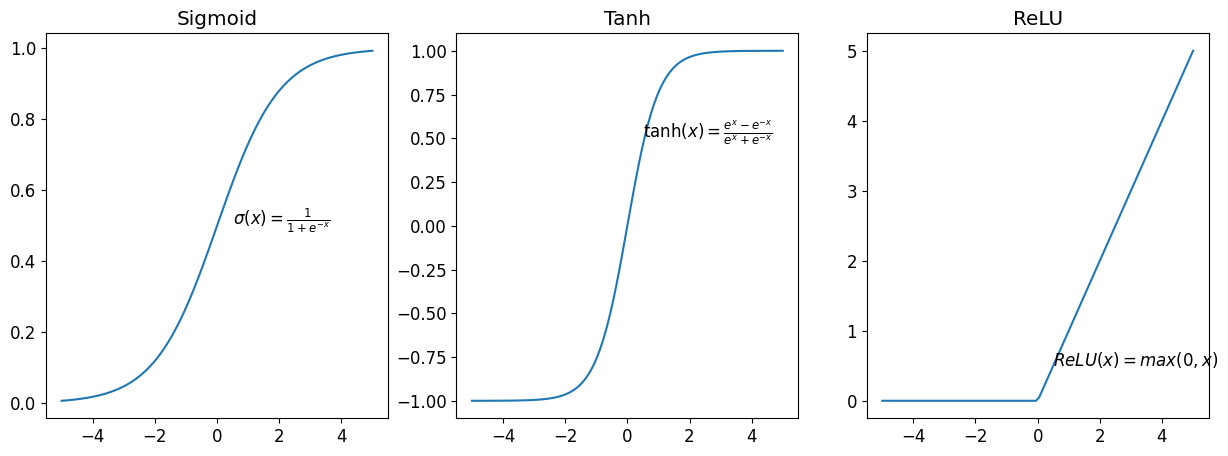

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Funciones de activacion
def sigmoid(x):
  return 1 / (1 + np.exp(-x))
def tanh(x):
  return np.tanh(x)
def relu(x):
  return np.maximum(0, x)

# Gráficas
x = np.linspace(-5, 5, 100)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Sigmoid
axes[0].plot(x, sigmoid(x))
axes[0].set_title('Sigmoid')
axes[0].text(0.5, 0.5, r'$\sigma(x) = \frac{1}{1 + e^{-x}}$', fontsize=12)

# Tanh
axes[1].plot(x, tanh(x))
axes[1].set_title('Tanh')
axes[1].text(0.5, 0.5, r'$\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$', fontsize=12)

# ReLU
axes[2].plot(x, relu(x))
axes[2].set_title('ReLU')
axes[2].text(0.5, 0.5, r'$ReLU(x) = max(0, x)$', fontsize=12)

plt.show()

¿Qué se usa, `CrossEntropyLoss` o `CrossEntropyLossFlat`? La diferencia es que el segundo es un wrapper del primero que nos simplifica el trabajo con salidas aplanadas, gestionando la dimensionalidad por nosotros. En general es más flexible y es lo más adecuado para nuestro problema. Además, las dos implementan `softmax` internamente, de modo que no hace falta incorporar `softmax` en la última capa. Es recomendable no añadir esta última capa ya que causa problemas, tiene que dejarse que `CrossEntropyLossFlat` aplique `softmax` internamente.

El `Learner` encapsula todo el proceso de entrenamiento, facilitándonos el trabajo. Recibe como parámetros nuestro dataloader y el modelo, junto con la función de pérdida, en nuestro caso `CrossEntropyLossFlat` y las métricas cuya evolución a lo largo del entrenamiento nos interesan (en nuestro caso accuracy y F1-score). También se puede especificar el optimizador, pero como por defecto se usa `Adam`, que es el que necesitamos en el apartado $4$, no lo especificamos.

<font color='blue'> 3. Desglosar detalladamente el número de parámetros de esta arquitectura, y cuánto contribuye cada capa a dicho número total. Se debe hacer un `summary()` del modelo para verificar que la arquitectura se ha construido adecuadamente y que el número de parámetros es correcto (es decir, se corresponde con lo esperado).

En capas convolucionales, la fórmula para calcular el número de parámetros es $(\mathrm{size}\cdot \mathrm{size} \cdot \mathrm{inchannels}+1)\cdot \mathrm{outchannels}$. En capas densas, es el producto de entradas por salidas, más un bias, que es el número de salidas (cada neurona tiene su propio bias, además de los pesos asociados a las entradas). Luego:


*   Conv2d: $(9\cdot 9 \cdot 3 + 1)\cdot 5 = 1220$
*   Sigmoid: no tiene
*   MaxPool2d: no tiene
*   Conv2d: $(7\cdot 7 \cdot 5 + 1)\cdot 10 = 2460$
*   Tanh: no tiene
*   Flatten: no tiene
*   Linear: $360\cdot 50 + 50 = 18050$
*   Linear: $50 \cdot 25 + 25 = 1275$
En total $23005$. Efectivamente, comprobamos que es así.


In [ ]:
learn.summary()

Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 5 x 24 x 24    
Conv2d                                    1220       True      
Sigmoid                                                        
____________________________________________________________________________
                     32 x 5 x 12 x 12    
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 10 x 6 x 6     
Conv2d                                    2460       True      
Tanh                                                           
____________________________________________________________________________
                     32 x 360            
Flatten                                                        
____________________________________________________________________________
                     32 x 50     

## <font color='blue'> **1.4 Entrenamiento y validación**


<font color='blue'> 4. Entrenar el modelo con _Adam_ (incluyendo _early stopping_ con una paciencia de $5$ durante $25$ épocas) y evaluar su rendimiento. En dicha evaluación se debe emplear/mostrar/analizar: la matriz de confusión en entrenamiento, validación y test; la _accuracy_ en entrenamiento, validación y test; y la evolución, por épocas de entrenamiento, tanto de la función de pérdida (en entrenamiento y validación) como de la _accuracy_ (en validación) y el _F1 score (weighted)_ (en validación).

Ahora vamos a entrenar el modelo. Para eso tenemos que añadir el callback del early stopping. Tenemos la tolerancia a $5$ y un `min_delta=0.01`, de modo que el entrenamiento se para si no mejoramos $0.01$ durante $5$ épocas. Entrenamos un máximo de $25$ épocas y con el 1cycle policy de Leslie N. Smith, para acelerar el entrenamiento. No establecemos el learning rate máximo y lo dejamos por defecto.

In [ ]:
# Entrenamiento
cbs=[EarlyStoppingCallback(min_delta=0.01, patience=5)]
learn.fit_one_cycle(n_epoch = 25, cbs=cbs)

No improvement since epoch 19: early stopping


Ahora vamos a visualizar la evolución de la pérdida, el accuracy y el f1_score a lo largo del entrenamiento.

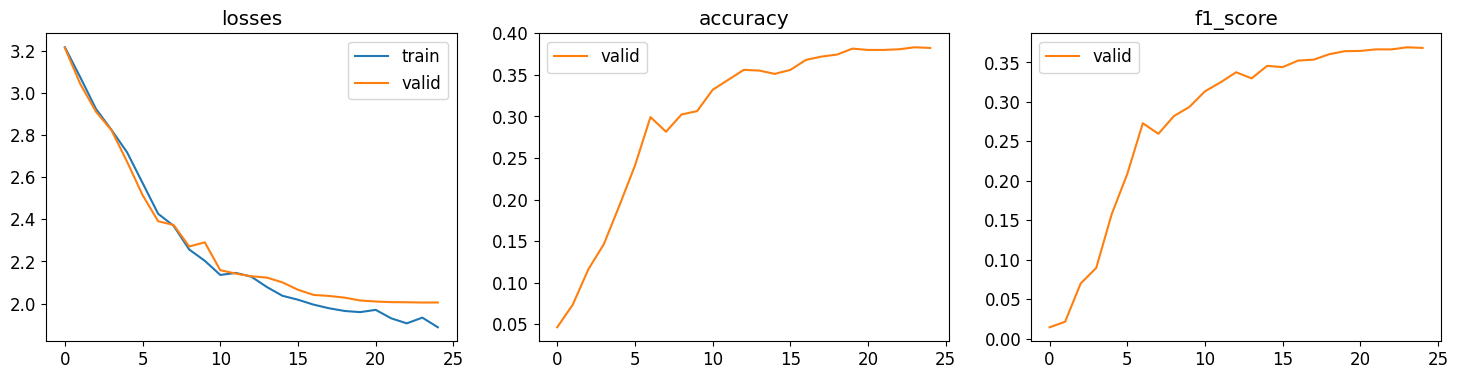

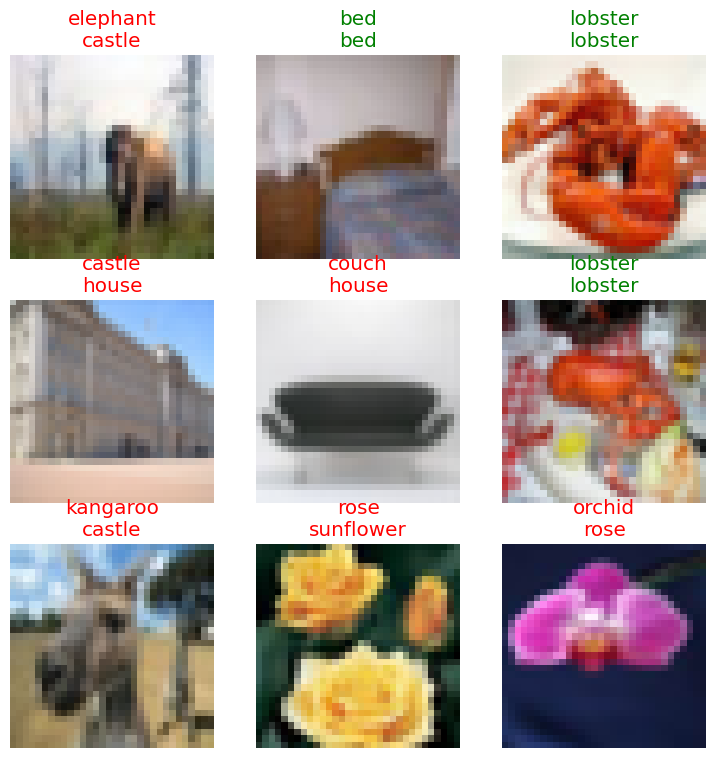

In [ ]:
# Mostrar las métricas en validación a lo largo de las diferentes épocas
learn.recorder.plot_metrics()
# Mostrar resultados tras el entrenamiento del modelo
learn.show_results()

Como podemos ver, la evolución de la pérdida muestra cierto sobreajuste, que tiene sentido teniendo en cuenta que no hemos hecho nada de regularización. Las métricas en validación crecen más o menos de forma estable, estancandose alrededor del $0.38$ en el caso de accuracy y $0.368$ en el caso del f1-score. En general el resultado es esperable para un modelo básico como el nuestro. Ahora procedemos a calcular el accuracy y las matrices de confusión para entrenamiento, validación y test. En el caso de entrenamiento y validación, el proceso es bastante simple ya que nuestro `Learner` guarda toda la información relevante del proceso de entrenamiento. Obtenemos las predicciones y las etiquetas verdaderas con `get_preds` y calculamos el accuracy en entrenamiento.

In [ ]:
# Generación de predicciones del modelo entrenado en el conjunto de entrenamiento
train_preds, train_targs, _ = learn.get_preds(dl = dls.train, with_decoded = True)

# Accuracy en el conjunto de entrenamiento
train_acc = accuracy(train_preds, train_targs)
print('\nACCURACY en el conjunto de ENTRENAMIENTO: ', round(float(train_acc) * 100, 4), '%')


ACCURACY en el conjunto de ENTRENAMIENTO:  42.1511 %


Obtenemos un $42\%$, no está muy mal teniendo en cuenta que es un problema de clasificación multiclase. Ahora calculamos la matriz de confusión con `ClassificationInterpretation`, que es una clase que nos ayuda analizar las predicciones del modelo. En particular nos permite calcular la matriz de confusión. Comprobamos que el número de ejemplos de entrenamiento es el que esperamos y graficamos la matriz.

Number of training examples: 11250


Training Accuracy
42.15111111111111


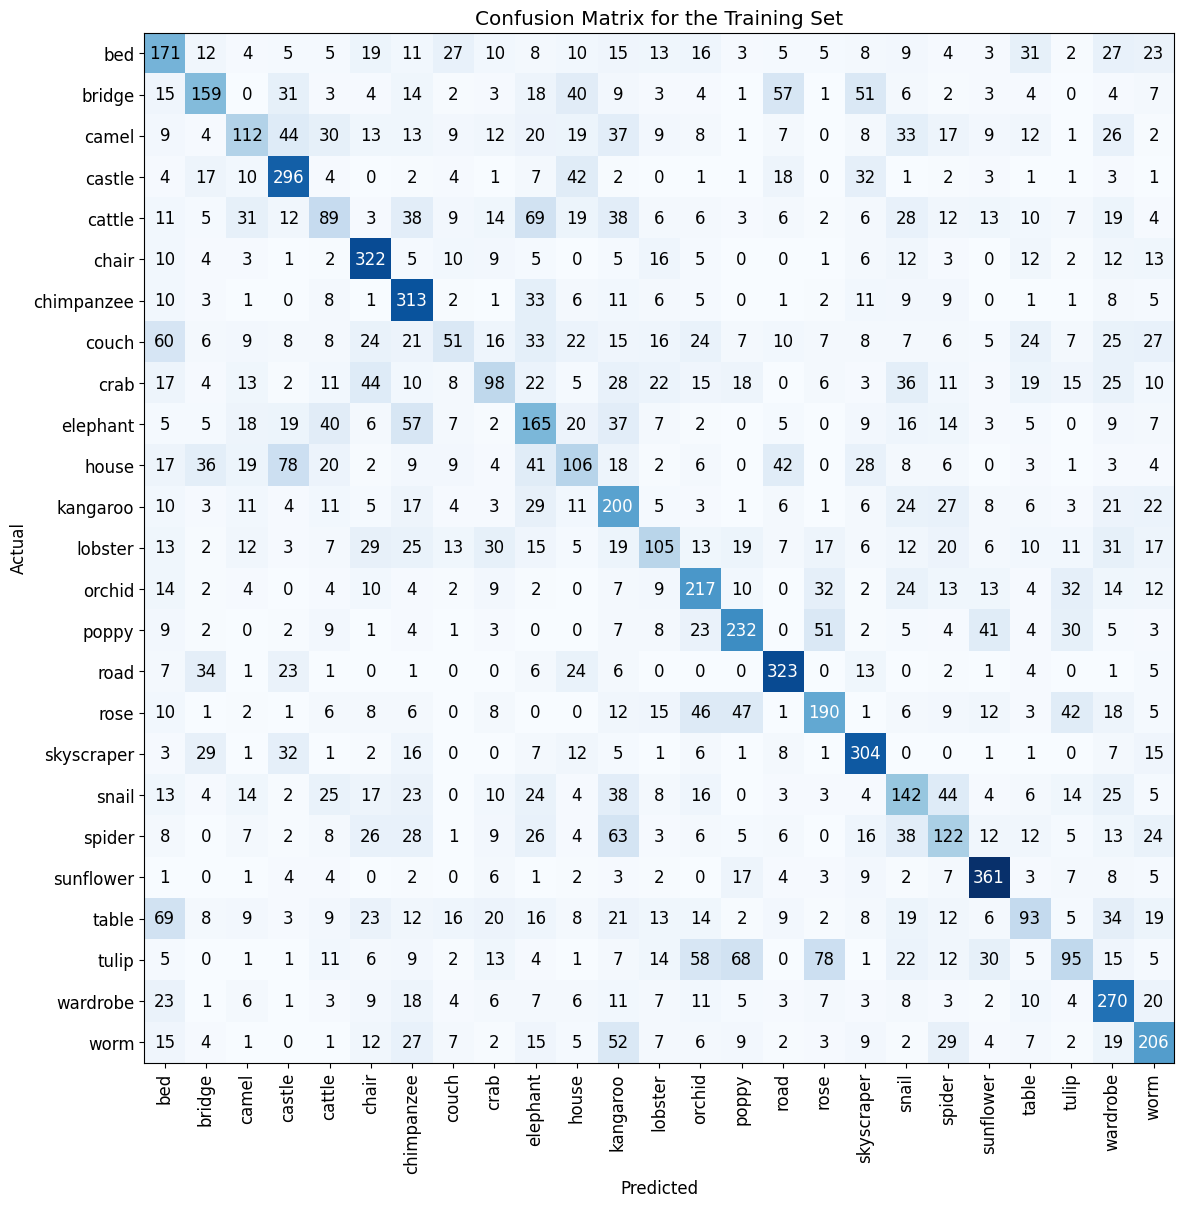

In [ ]:
# Matriz de confusión
interp_train = ClassificationInterpretation.from_learner(learn, 1, dls.train)
cm_train = interp_train.confusion_matrix()
print('Number of training examples:', np.sum(cm_train))
interp_train.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Training Set')
print('Training Accuracy')
print(np.sum(np.diagonal(cm_train))/np.sum(cm_train)*100)

No vamos a describir todo lo que hay en la matriz ya que es demasiado, pero como ejemplo, podemos ver que los girasoles tienen bastante éxito al clasificarse. Viendo la fila de los girasoles, vemos que casi nunca un girasol se predice como algo que no es un girasol, aunque viendo la columna de las predicciones girasol, parece que muchas tulipas y amapolas se predicen incorrectamente como girasoles. Entre cosas que se predicen mal, también observamos que muchas casas se clasifican incorrectamente como castillos, cosa que tiene sentido. Viceversa también sucede. En general, se puede llegar a la conclusión de que el modelo es mejorable y confunde muchas cosas parecidas. Hay que aprender mejor las características de las distintas clases.

Ahora procedemos a analizar el conjunto de validación.

In [ ]:
# Generación de predicciones del modelo entrenado en el conjunto de validación
valid_preds, valid_targs, _ = learn.get_preds(dl = dls.valid, with_decoded = True)

# Accuracy en el conjunto de validación
valid_acc = accuracy(valid_preds, valid_targs)
print('\nACCURACY en el conjunto de VALIDACIÓN: ', round(float(valid_acc) * 100, 4), '%')


ACCURACY en el conjunto de VALIDACIÓN:  38.24 %


Vemos que con un $38\%$ de accuracy, parece que comparado con el $42\%$ de entrenamiento hay cierto sobreajuste.

Number of validation examples: 1250


Validation Accuracy
38.24


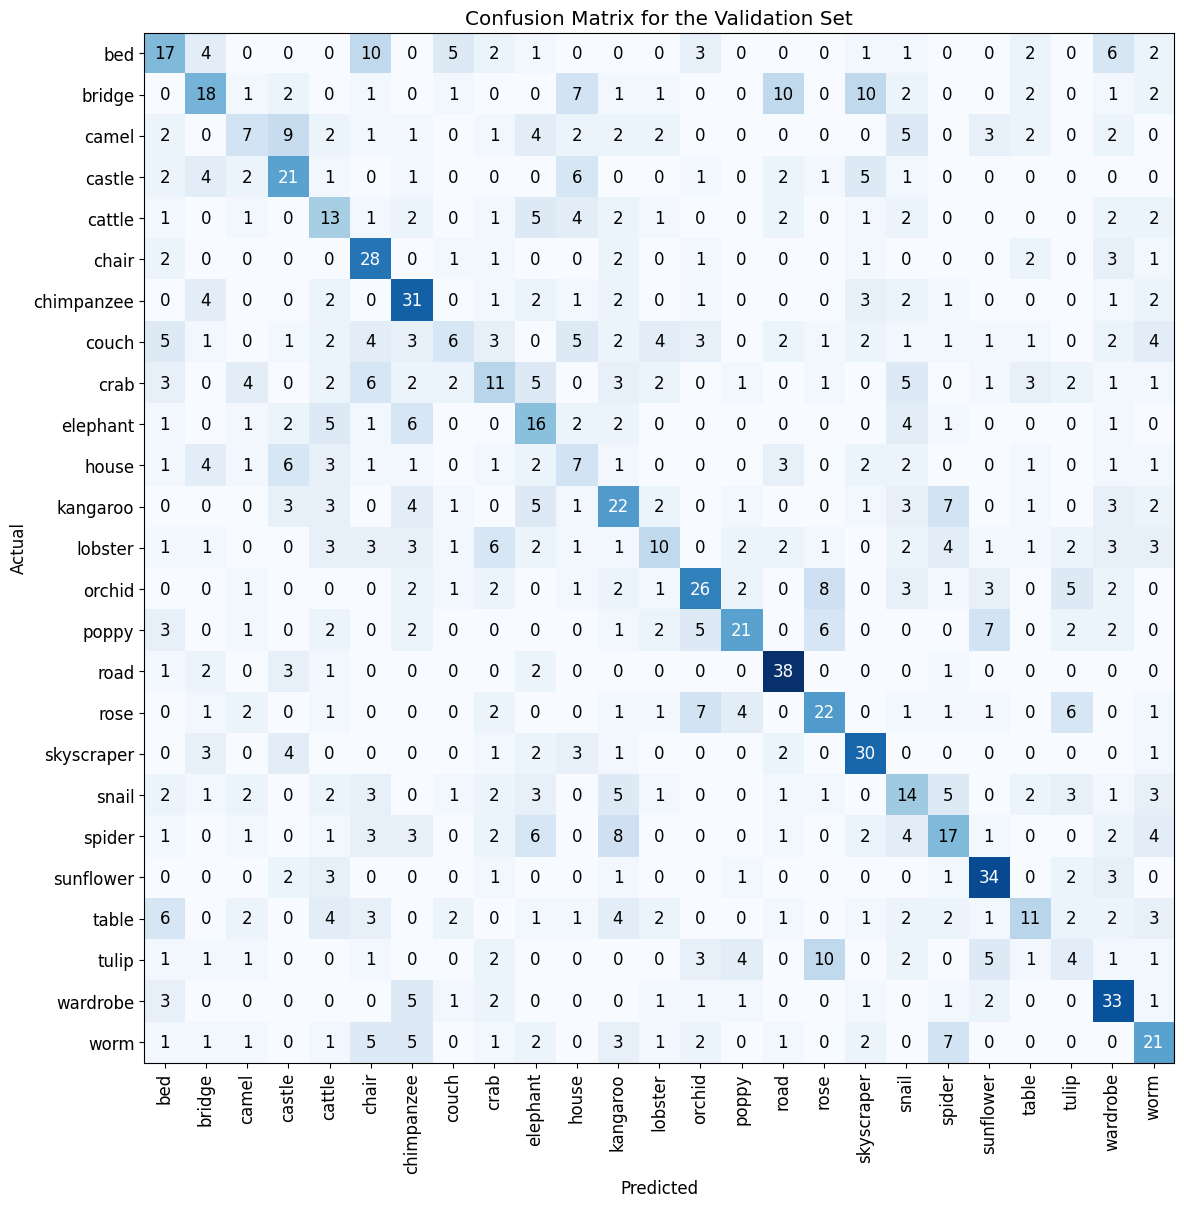

In [ ]:
# Matriz de confusión
interp_valid = ClassificationInterpretation.from_learner(learn, 1, dls.valid)
cm_valid = interp_valid.confusion_matrix()
print('Number of validation examples:', np.sum(cm_valid))
interp_valid.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Validation Set')
print('Validation Accuracy')
print(np.sum(np.diagonal(cm_valid))/np.sum(cm_valid)*100)

Observando la matriz de confusión de validación, se observa algo parecido a la matriz anterior. Veamos el test.

In [ ]:
# Definición del dataloader para el conjunto de test
test_dl = learn.dls.test_dl(files_test, with_labels = True)

# Generación de predicciones del modelo entrenado en el conjunto de test
preds, targs, _ = learn.get_preds(dl = test_dl, with_decoded = True)

# Accuracy en el conjunto de test
test_acc = accuracy(preds, targs)
print('\nACCURACY en el conjunto TEST: ', round(float(test_acc) * 100, 4), '%')


ACCURACY en el conjunto TEST:  38.0 %


El accuracy nos sale similar al de validación. Parece que tenemos algo de overfitting, como ya mencionamos antes.

Number of test examples: 2500


Test Accuracy
38.0


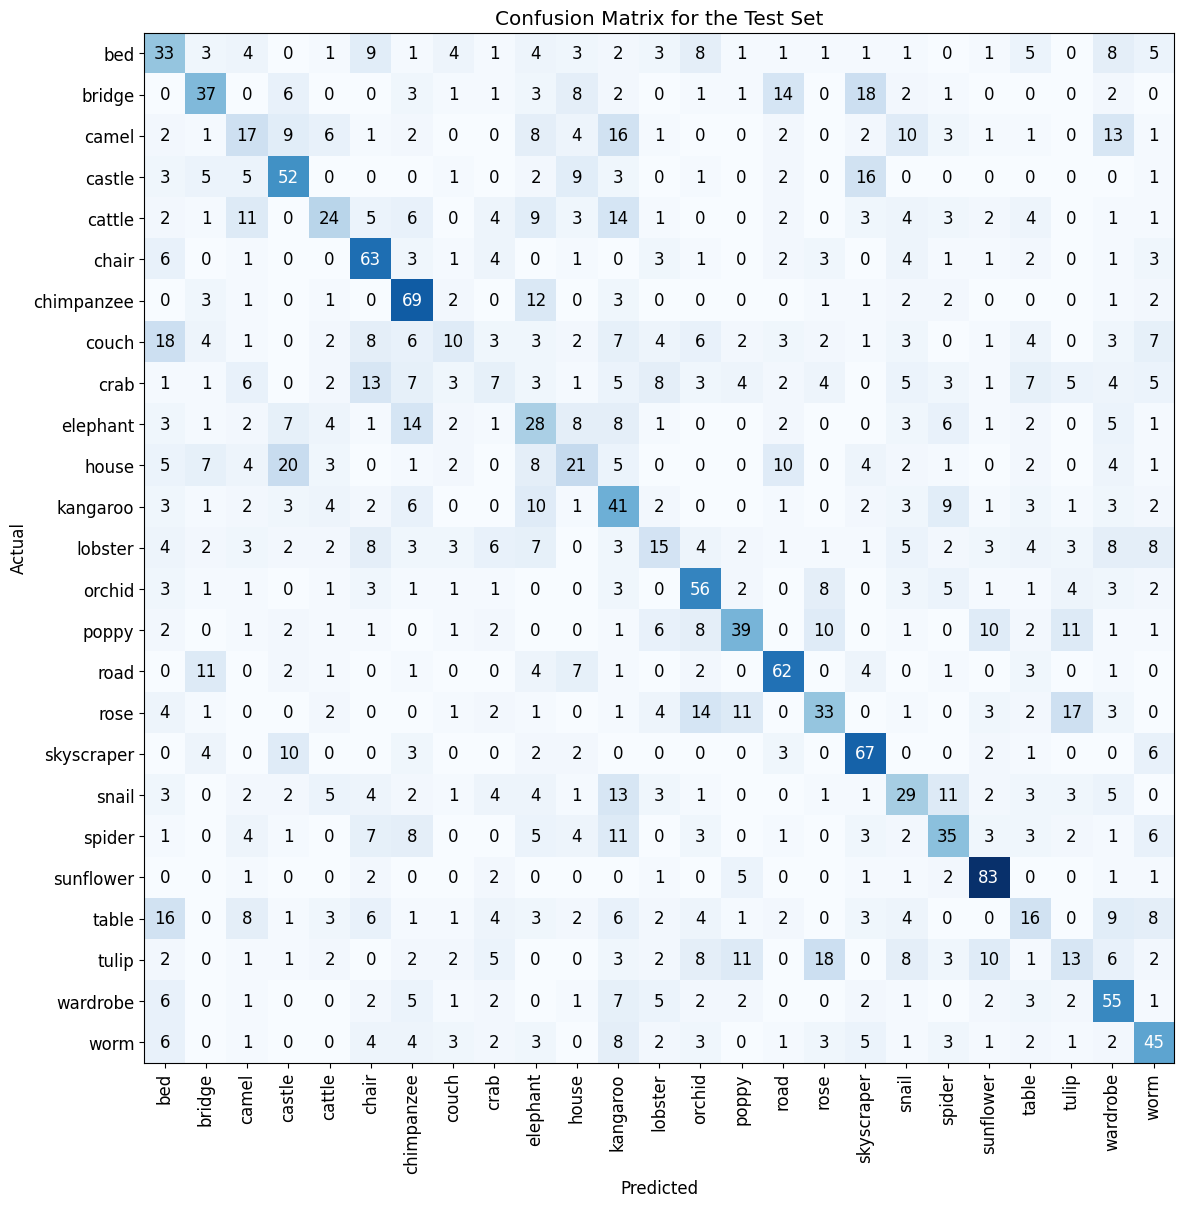

In [ ]:
# Matriz de confusión
interp_test = ClassificationInterpretation.from_learner(learn, 1, test_dl)
cm_test = interp_test.confusion_matrix()
print('Number of test examples:', np.sum(cm_test))
interp_test.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Test Set')
print('Test Accuracy')
print(np.sum(np.diagonal(cm_test))/np.sum(cm_test)*100)

Misma situación con la matriz de confusión de test. En general, un análisis de las matrices de confusión nos puede dar algunas ideas de qué podría mejorarse en el siguiente ejercicio. Viendo como se confunden clases que tienen características parecidas, quizá sea buena idea añadir más capas de convolución y no hacer pooling tan temprano. Parece que perdemos información demasiado rápido.

# <font color='blue'> **Ejercicio 2:** **Mejoras sobre el modelo BaseNet (4 puntos)**
<font color='blue'>Ahora el objetivo es crear una versión mejorada del modelo _Base Net_ (implementado en el anterior apartado). Para ello, se puede experimentar con distintas funciones de activación, funciones de pérdida, una mayor o menor profundidad de la red, un mayor o menor número de filtros por bloque convolucional, y/o diferentes técnicas de regularización u optimización, entre otras. De hecho, los alumnos deben sentirse libres para experimentar e incorporar todas las modificaciones que consideren pertinentes, incluyendo elementos no vistos ni en teoría ni en prácticas (por ejemplo, componentes que hayan podido descubrir a través de la revisión de artículos científicos). **Se valorará la originalidad y complejidad de la propuesta realizada.**

<font color='blue'>Es necesario destacar que **es imprescindible justificar de la mejor forma posible las decisiones tomadas** (ya sea mediante evidencia empírica o mediante literatura científica), **así como el rendimiento obtenido** (esto es, intentar explicar qué es lo que hace que mejore tanto el rendimiento). También es importante remarcar que **las mejoras introducidas, dentro de lo posible, deben realizarse de forma incremental**, es decir, no basta con crear directamente (de forma mágica) un único modelo y evaluarlo:  **es necesario justificar y describir qué pasos y resultados intermedios nos han llevado a diseñar ese modelo concreto**. Se debe describir cada una de las mejoras incorporadas, así como analizar los resultados obtenidos (del mismo modo que se hizo en el Ejercicio 1, y empleando los mismos criterios de partida; por ejemplo, usando un $10\%$ de los ejemplos de entrenamiento para validación). También es necesario, al igual que en el Ejercicio 1, desglosar el número de parámetros del modelo final, y se debe hacer un `summary()` del modelo para verificar que la arquitectura se ha construido correctamente y que el número de parámetros se corresponde con lo esperado.  

<font color='blue'>Como referencia para los estudiantes, se espera que la _accuracy_ en validación alcance, como mínimo, el $65\%$.


Vamos a usar accuracy como métrica para evaluar los modelos intermedios, y ya con el modelo final vemos las matrices de confusión. Para evaluar más fácil los modelos, creo una función que reuna todo. Ademas reduciremos el número de épocas, como hemos visto en el ejercicio anterior, tenemos overfitting con 25 épocas, así que entrenaremos con 15.

In [10]:
def results(learn, dls):
  # Mostrar las métricas en validación a lo largo de las diferentes épocas
  learn.recorder.plot_metrics()
  # Mostrar resultados tras el entrenamiento del modelo
  learn.show_results()

  # Generación de predicciones del modelo entrenado en el conjunto de entrenamiento
  train_preds, train_targs, _ = learn.get_preds(dl = dls.train, with_decoded = True)
  # Accuracy en el conjunto de entrenamiento
  train_acc = accuracy(train_preds, train_targs)
  print('\nACCURACY en el conjunto de ENTRENAMIENTO: ', round(float(train_acc) * 100, 4), '%')

  # Generación de predicciones del modelo entrenado en el conjunto de validación
  valid_preds, valid_targs, _ = learn.get_preds(dl = dls.valid, with_decoded = True)
  # Accuracy en el conjunto de validación
  valid_acc = accuracy(valid_preds, valid_targs)
  print('\nACCURACY en el conjunto de VALIDACIÓN: ', round(float(valid_acc) * 100, 4), '%')

## <font color='blue'> **2.0 Modelo Base**

Debido a que he ejecutado el ejercicio 1 y 2 en sesiones distintas, entrenaré de nuevo el modelo base para poder comparar las mejoras.

En cada apartado de las mejoras que vamos haciendo introduciremos un BaseNet del apartado, junto con su DataBlock, DataLoader y Learner correspondientes.

In [11]:
# BaseNet
BaseNet0 = sequential(
    nn.Conv2d(in_channels = 3, out_channels = 5, kernel_size = (9,9)),  # Capa 1: Convolución
    nn.Sigmoid(),                                                       # Capa 2: Sigmoide
    nn.MaxPool2d(kernel_size = (2,2)),                                  # Capa 3: MaxPooling2D
    nn.Conv2d(in_channels = 5, out_channels = 10, kernel_size = (7,7)), # Capa 4: Convolución
    nn.Tanh(),                                                          # Capa 5: Tanh
    nn.Flatten(),                                                       # Capa 6: Flatten
    nn.Linear(in_features = 360, out_features = 50),                    # Capa 7: Fully-Connected
    nn.ReLU(),                                                          # Capa 8: ReLU
    nn.Linear(in_features = 50, out_features = 25)                      # Capa 9: Fully-Connected
    # nn.Softmax()
)

BaseNet0

Sequential(
  (0): Conv2d(3, 5, kernel_size=(9, 9), stride=(1, 1))
  (1): Sigmoid()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(5, 10, kernel_size=(7, 7), stride=(1, 1))
  (4): Tanh()
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=360, out_features=50, bias=True)
  (7): ReLU()
  (8): Linear(in_features=50, out_features=25, bias=True)
)

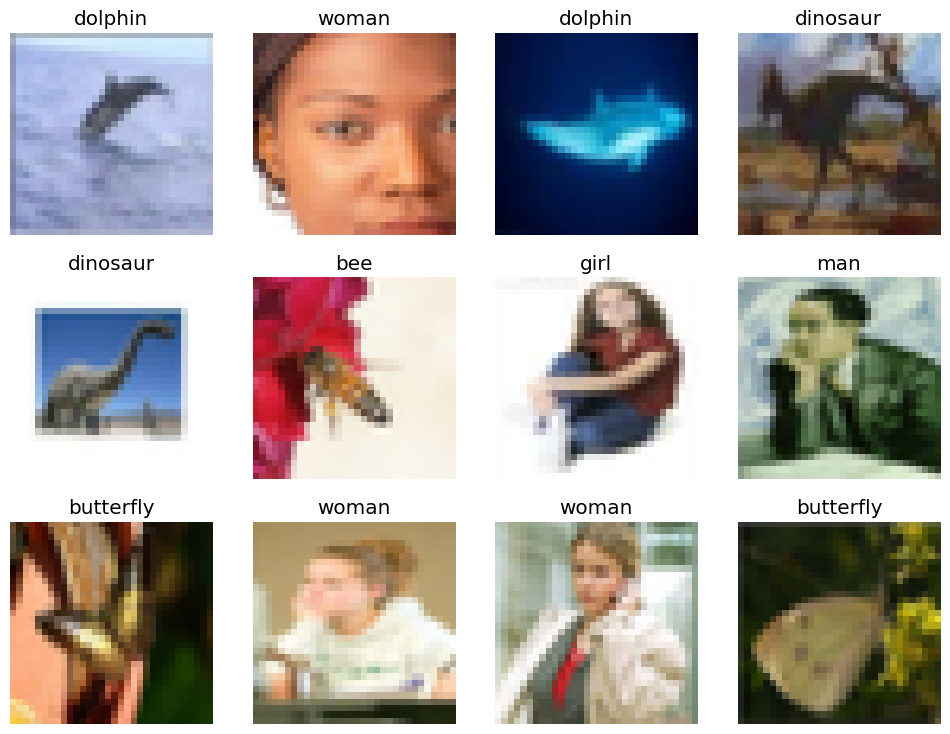

In [12]:
# Datablock
db0 = DataBlock(
  blocks    = (ImageBlock, CategoryBlock),                  # Tipos de datos de entrada y salida
  get_items = get_image_files,                              # Extraer imágenes
  splitter  = RandomSplitter(valid_pct = 0.1, seed = 42),   # Entrenamiento y validación (90%/10%)
  get_y     = parent_label                                 # Etiquetas
)

# Dataloader del conjunto de entrenamiento
dls0 = db0.dataloaders(path/'train', bs = 32)
# Imprimir un batch, con no más de 12 ejemplos
dls0.show_batch(max_n=12)

In [13]:
# Learner
learn0 = Learner(dls0, BaseNet0, loss_func = CrossEntropyLossFlat(), metrics = [accuracy, F1Score(average='weighted')])
learn0.summary()

Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 5 x 24 x 24    
Conv2d                                    1220       True      
Sigmoid                                                        
____________________________________________________________________________
                     32 x 5 x 12 x 12    
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 10 x 6 x 6     
Conv2d                                    2460       True      
Tanh                                                           
____________________________________________________________________________
                     32 x 360            
Flatten                                                        
____________________________________________________________________________
                     32 x 50     

In [14]:
# Entrenamiento
cbs=[EarlyStoppingCallback(min_delta=0.01, patience=5)]
learn0.fit_one_cycle(n_epoch = 15, cbs=cbs)

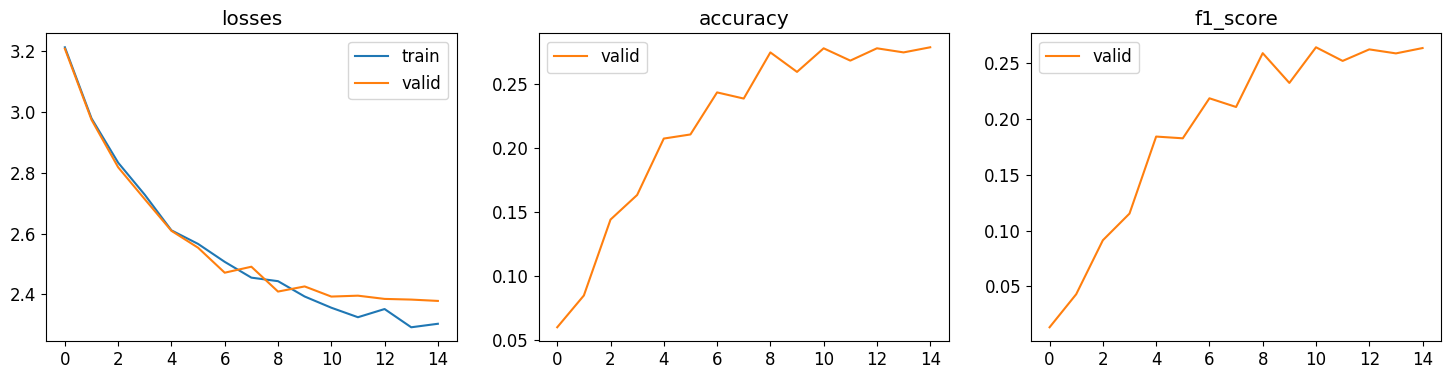


ACCURACY en el conjunto de ENTRENAMIENTO:  29.8489 %



ACCURACY en el conjunto de VALIDACIÓN:  27.84 %


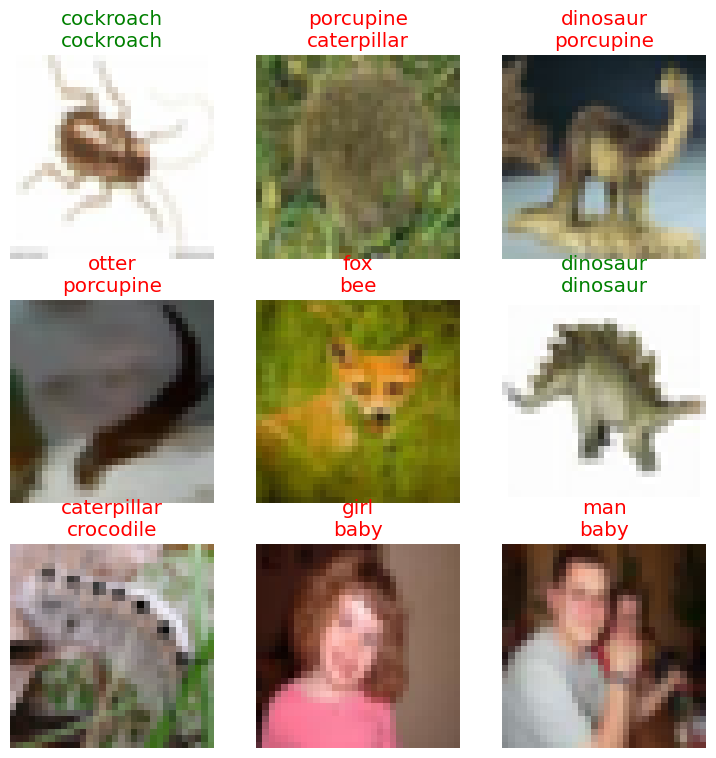

In [15]:
results(learn0, dls0)

Obtenemos un accuracy de 27.84%. Usaremos este para comparar con las mejoras. En el modelo base se observa algo de overfitting al final, sabemos que tenemos que regularizar de alguna forma.

## <font color='blue'> **2.1 Data Normalization**

La normalización de datos es una técnica muy recomendada en el deep learning. Igual que en muchos algoritmos de aprendizaje automático, normalizar nos ayuda converger más rápido, estabilizar y acelerar el entrenamiento, y prevenir problemas con gradientes explosivos o desvanecientes. Igual que en AA, si normalizamos en entrenamiento hay que normalizar en test, pero como `fastai` se ocupa de hacer eso por nosotros con `get_preds`, nos podemos olvidar de eso, aunque es importante tenerlo en cuenta. Para normalizar los batches en fastai se pueden usar varias técnicas: normalizar con media y desviación típica precalculada para nuestro dataset CIFAR100, normalizar calculando nosotros la media y la desviación, o normalizar con media y desviación personalizada por nosotros. Optamos por la opción de reutilizar los estadísticos precalculados, que es la mejor opción por defecto.

In [16]:
# BaseNet
BaseNet1 = sequential(
    nn.Conv2d(in_channels = 3, out_channels = 5, kernel_size = (9,9)),  # Capa 1: Convolución
    nn.Sigmoid(),                                                       # Capa 2: Sigmoide
    nn.MaxPool2d(kernel_size = (2,2)),                                  # Capa 3: MaxPooling2D
    nn.Conv2d(in_channels = 5, out_channels = 10, kernel_size = (7,7)), # Capa 4: Convolución
    nn.Tanh(),                                                          # Capa 5: Tanh
    nn.Flatten(),                                                       # Capa 6: Flatten
    nn.Linear(in_features = 360, out_features = 50),                    # Capa 7: Fully-Connected
    nn.ReLU(),                                                          # Capa 8: ReLU
    nn.Linear(in_features = 50, out_features = 25)                      # Capa 9: Fully-Connected
    # nn.Softmax()
)

BaseNet1

Sequential(
  (0): Conv2d(3, 5, kernel_size=(9, 9), stride=(1, 1))
  (1): Sigmoid()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(5, 10, kernel_size=(7, 7), stride=(1, 1))
  (4): Tanh()
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=360, out_features=50, bias=True)
  (7): ReLU()
  (8): Linear(in_features=50, out_features=25, bias=True)
)

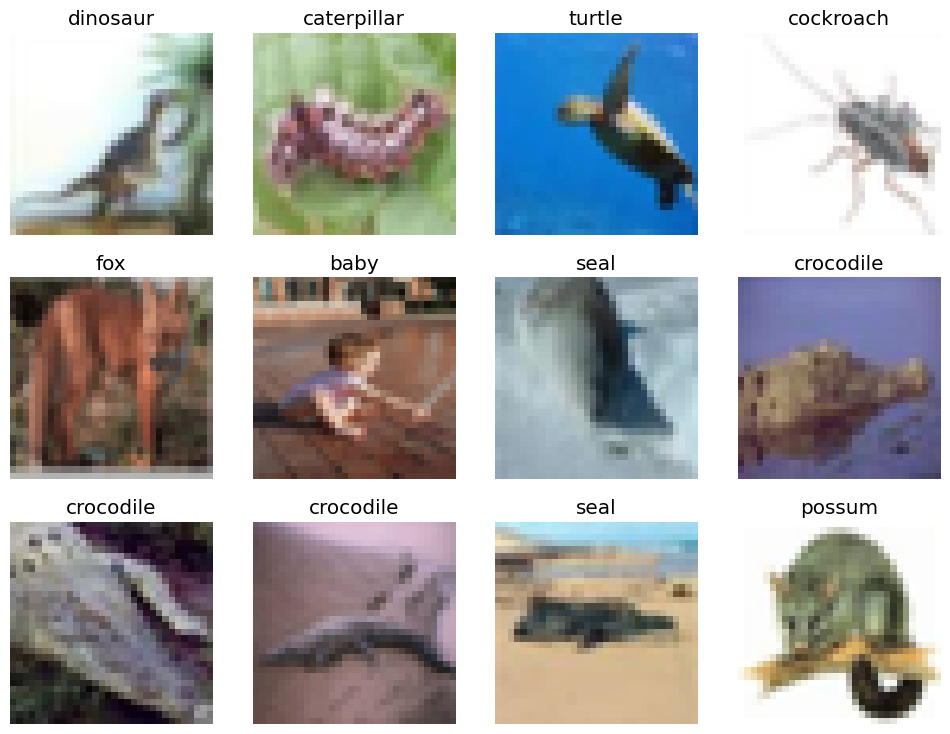

In [17]:
# Datablock
db1 = DataBlock(
  blocks    = (ImageBlock, CategoryBlock),                  # Tipos de datos de entrada y salida
  get_items = get_image_files,                              # Extraer imágenes
  splitter  = RandomSplitter(valid_pct = 0.1, seed = 42),   # Entrenamiento y validación (90%/10%)
  get_y     = parent_label,                                 # Etiquetas
  batch_tfms = Normalize.from_stats(*cifar_stats)           # MEJORA: normalizar
)

# Dataloader del conjunto de entrenamiento
dls1 = db1.dataloaders(path/'train', bs = 32)
# Imprimir un batch, con no más de 12 ejemplos
dls1.show_batch(max_n=12)

In [18]:
# Learner
learn1 = Learner(dls1, BaseNet1, loss_func = CrossEntropyLossFlat(), metrics = [accuracy, F1Score(average='weighted')])
learn1.summary()

Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 5 x 24 x 24    
Conv2d                                    1220       True      
Sigmoid                                                        
____________________________________________________________________________
                     32 x 5 x 12 x 12    
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 10 x 6 x 6     
Conv2d                                    2460       True      
Tanh                                                           
____________________________________________________________________________
                     32 x 360            
Flatten                                                        
____________________________________________________________________________
                     32 x 50     

In [19]:
# Entrenamiento
cbs=[EarlyStoppingCallback(min_delta=0.01, patience=5)]
learn1.fit_one_cycle(n_epoch = 15, cbs=cbs)

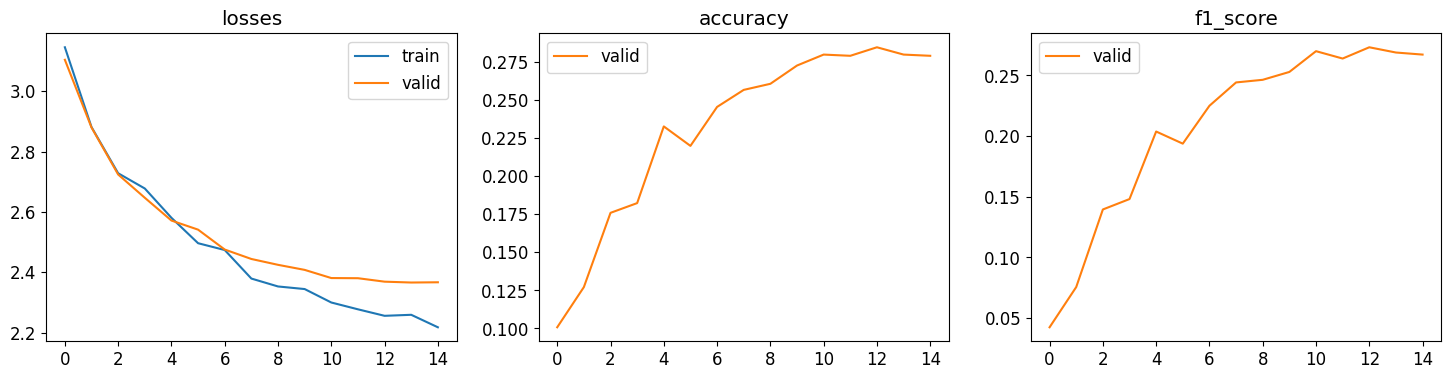


ACCURACY en el conjunto de ENTRENAMIENTO:  32.3733 %



ACCURACY en el conjunto de VALIDACIÓN:  27.92 %


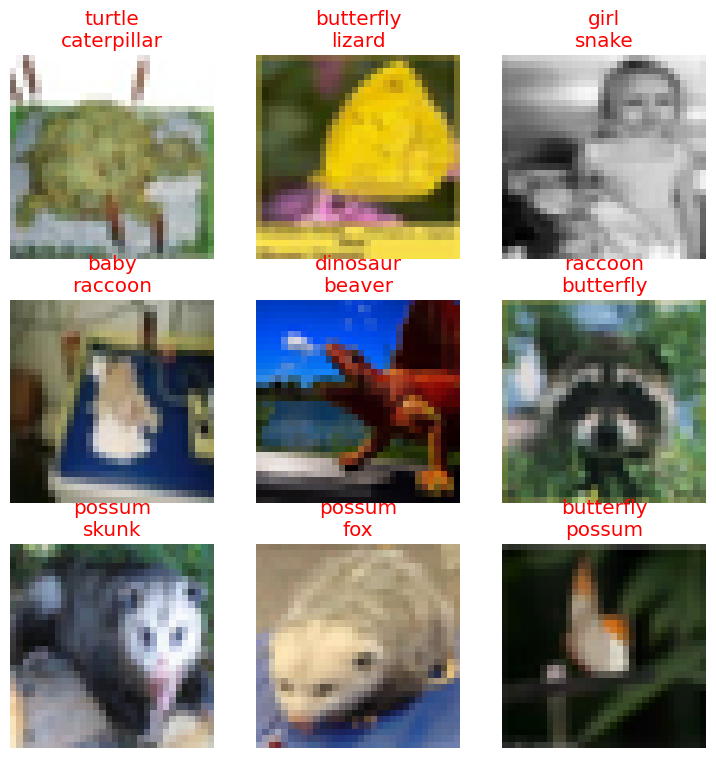

In [20]:
results(learn1, dls1)

27.92%, una pequeña mejora frente al modelo base con 27.84%. Parece que normalizar está bien, aunque la mejora es tan pequeña que realmente no se puede asegurar nada. En general se conoce que normalizar los datos es buena idea, así que en el modelo final lo consideramos.

## <font color='blue'> **2.2 Data augmentation**

El Data Augmentation es una técnica que ayuda al modelo a generalizar y evitar el overfitting. Consiste en aplicar transformaciones geométricas, como rotaciones, zoom, traslaciones y reflexiones, entre otras. Con esta técnica se amplía el conjunto de entrenamiento, lo cual permite al modelo evitar el sobreajuste, generalizar mejor y mantenerse invariante a transformaciones de este tipo. En `fastai` simplemente añadimos `aug_transforms` en `batch_tfms`, que por defecto proporciona transformaciones en general bastante buenas, aunque podemos especificar qué queremos en concreto. Nosotros dejaremos que `fastai` aplique las transformaciones que considere más oportunas.

In [21]:
# BaseNet
BaseNet2 = sequential(
    nn.Conv2d(in_channels = 3, out_channels = 5, kernel_size = (9,9)),  # Capa 1: Convolución
    nn.Sigmoid(),                                                       # Capa 2: Sigmoide
    nn.MaxPool2d(kernel_size = (2,2)),                                  # Capa 3: MaxPooling2D
    nn.Conv2d(in_channels = 5, out_channels = 10, kernel_size = (7,7)), # Capa 4: Convolución
    nn.Tanh(),                                                          # Capa 5: Tanh
    nn.Flatten(),                                                       # Capa 6: Flatten
    nn.Linear(in_features = 360, out_features = 50),                    # Capa 7: Fully-Connected
    nn.ReLU(),                                                          # Capa 8: ReLU
    nn.Linear(in_features = 50, out_features = 25)                      # Capa 9: Fully-Connected
    # nn.Softmax()
)

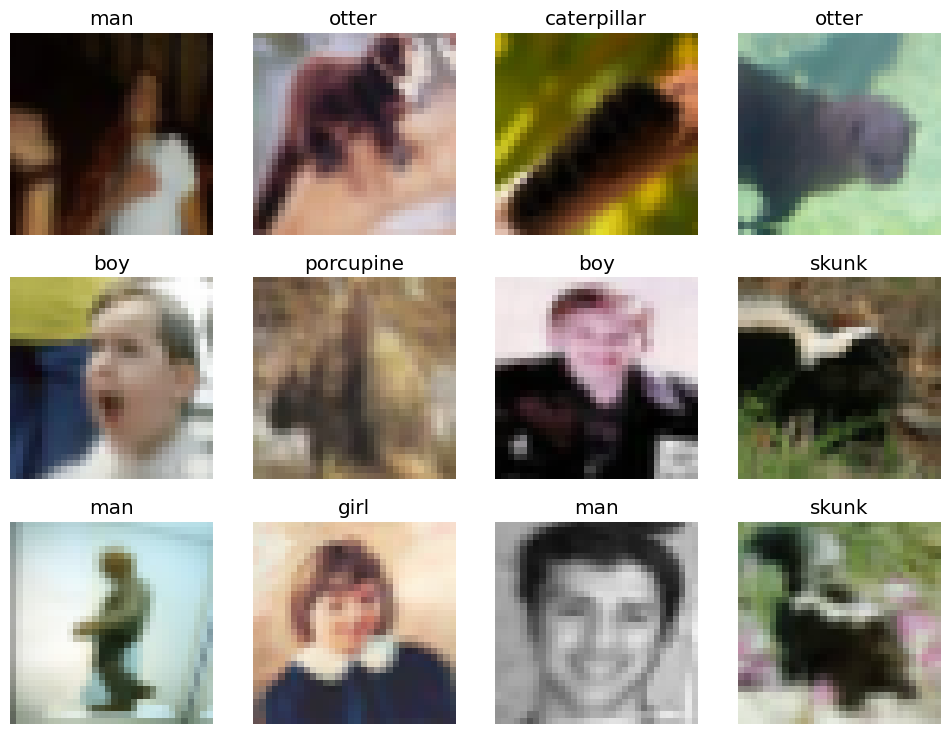

In [22]:
# Datablock
db2 = DataBlock(
  blocks    = (ImageBlock, CategoryBlock),                  # Tipos de datos de entrada y salida
  get_items = get_image_files,                              # Extraer imágenes
  splitter  = RandomSplitter(valid_pct = 0.1, seed = 42),   # Entrenamiento y validación (90%/10%)
  get_y     = parent_label,                                 # Etiquetas
  batch_tfms = aug_transforms()                             # MEJORA: data augmentation
)

# Dataloader del conjunto de entrenamiento
dls2 = db2.dataloaders(path/'train', bs = 32)
# Imprimir un batch, con no más de 12 ejemplos
dls2.show_batch(max_n=12)

In [23]:
# Learner
learn2 = Learner(dls2, BaseNet2, loss_func = CrossEntropyLossFlat(), metrics = [accuracy, F1Score(average='weighted')])
learn2.summary()

Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 5 x 24 x 24    
Conv2d                                    1220       True      
Sigmoid                                                        
____________________________________________________________________________
                     32 x 5 x 12 x 12    
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 10 x 6 x 6     
Conv2d                                    2460       True      
Tanh                                                           
____________________________________________________________________________
                     32 x 360            
Flatten                                                        
____________________________________________________________________________
                     32 x 50     

In [24]:
# Entrenamiento
cbs=[EarlyStoppingCallback(min_delta=0.01, patience=5)]
learn2.fit_one_cycle(n_epoch = 15, cbs=cbs)

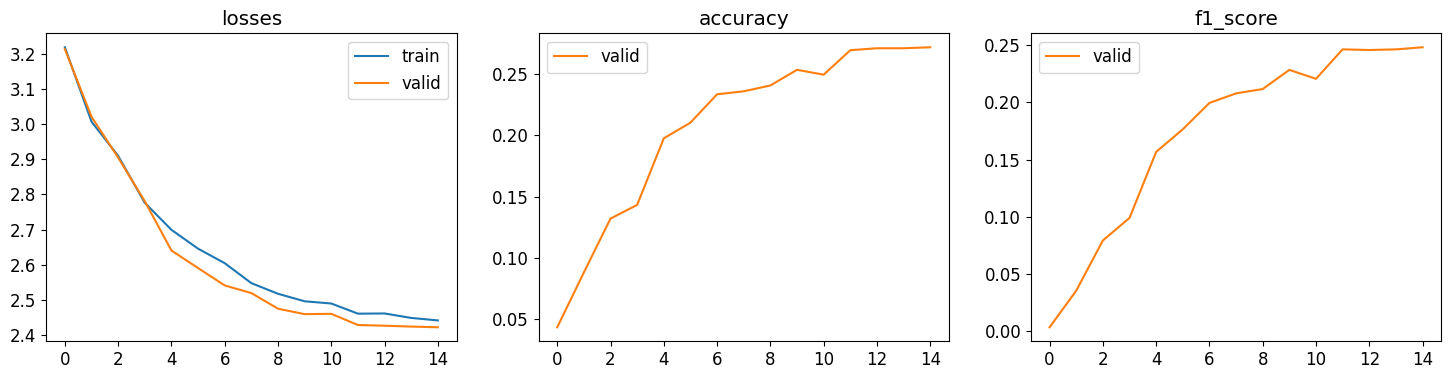


ACCURACY en el conjunto de ENTRENAMIENTO:  26.7644 %



ACCURACY en el conjunto de VALIDACIÓN:  27.2 %


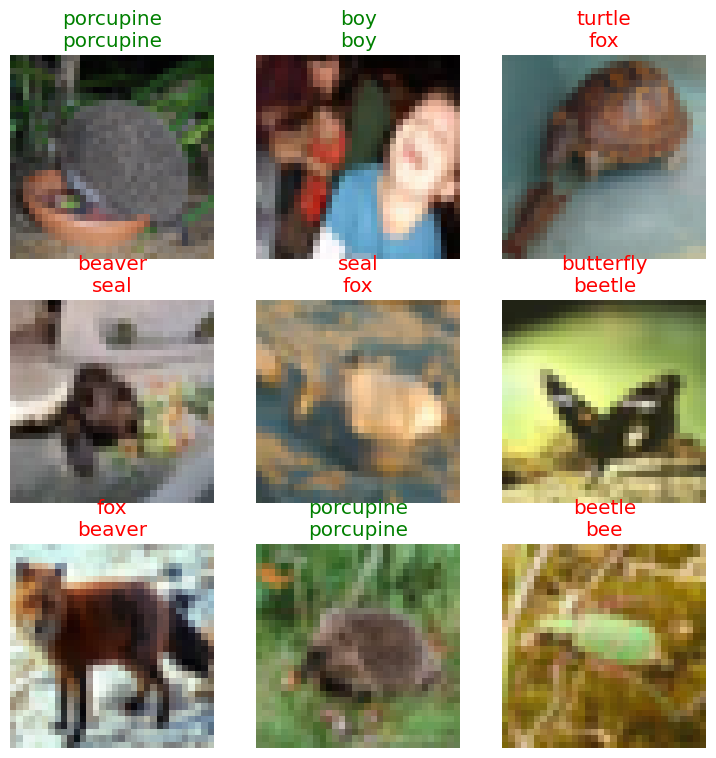

In [25]:
results(learn2, dls2)

27.2%, un empeoramiento frente a 27.84%, que es normal, teniendo en cuenta que estamos complicando el dataset con data augmentation. A lo mejor a la larga ayudaría al modelo a generalizar.

## <font color='blue'> **2.3 Funciones de activación**

En general, debido a los problemas de gradiente desvaneciente, las funciones de activación sigmoide y tanh no se suelen usar mucho, la opción estándar suele ser ReLU. Aunque también es verdad que esta sufre de sus propios problemas, como ReLUs muertas, pero es una opción en general considerada bastante buena. Vamos a usar ReLUs en vez de sigmoides y tanh.

In [26]:
# BaseNet
BaseNet3 = sequential(
    nn.Conv2d(in_channels = 3, out_channels = 5, kernel_size = (9,9)),  # Capa 1: Convolución
    nn.ReLU(),                                                          # Capa 2: ReLU
    nn.MaxPool2d(kernel_size = (2,2)),                                  # Capa 3: MaxPooling2D
    nn.Conv2d(in_channels = 5, out_channels = 10, kernel_size = (7,7)), # Capa 4: Convolución
    nn.ReLU(),                                                          # Capa 5: ReLU
    nn.Flatten(),                                                       # Capa 6: Flatten
    nn.Linear(in_features = 360, out_features = 50),                    # Capa 7: Fully-Connected
    nn.ReLU(),                                                          # Capa 8: ReLU
    nn.Linear(in_features = 50, out_features = 25)                      # Capa 9: Fully-Connected
    # nn.Softmax()
)

BaseNet3

Sequential(
  (0): Conv2d(3, 5, kernel_size=(9, 9), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(5, 10, kernel_size=(7, 7), stride=(1, 1))
  (4): ReLU()
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=360, out_features=50, bias=True)
  (7): ReLU()
  (8): Linear(in_features=50, out_features=25, bias=True)
)

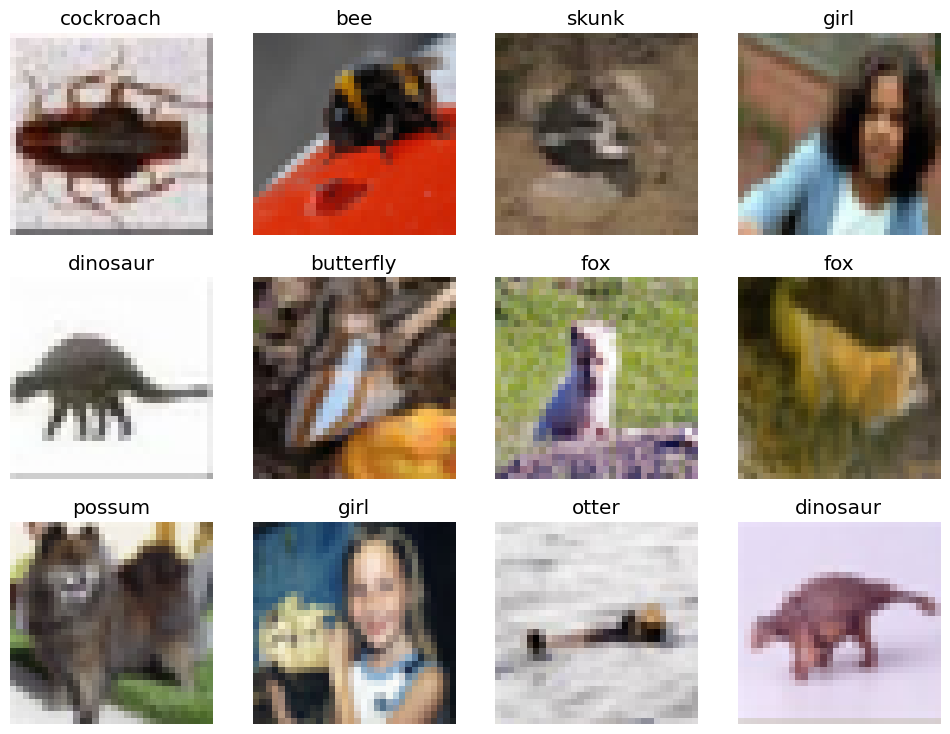

In [27]:
# Datablock
db3 = DataBlock(
  blocks    = (ImageBlock, CategoryBlock),                  # Tipos de datos de entrada y salida
  get_items = get_image_files,                              # Extraer imágenes
  splitter  = RandomSplitter(valid_pct = 0.1, seed = 42),   # Entrenamiento y validación (90%/10%)
  get_y     = parent_label                                 # Etiquetas
)

# Dataloader del conjunto de entrenamiento
dls3 = db3.dataloaders(path/'train', bs = 32)
# Imprimir un batch, con no más de 12 ejemplos
dls3.show_batch(max_n=12)

In [28]:
# Learner
learn3 = Learner(dls3, BaseNet3, loss_func = CrossEntropyLossFlat(), metrics = [accuracy, F1Score(average='weighted')])
learn3.summary()

Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 5 x 24 x 24    
Conv2d                                    1220       True      
ReLU                                                           
____________________________________________________________________________
                     32 x 5 x 12 x 12    
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 10 x 6 x 6     
Conv2d                                    2460       True      
ReLU                                                           
____________________________________________________________________________
                     32 x 360            
Flatten                                                        
____________________________________________________________________________
                     32 x 50     

In [29]:
# Entrenamiento
cbs=[EarlyStoppingCallback(min_delta=0.01, patience=5)]
learn3.fit_one_cycle(n_epoch = 15, cbs=cbs)

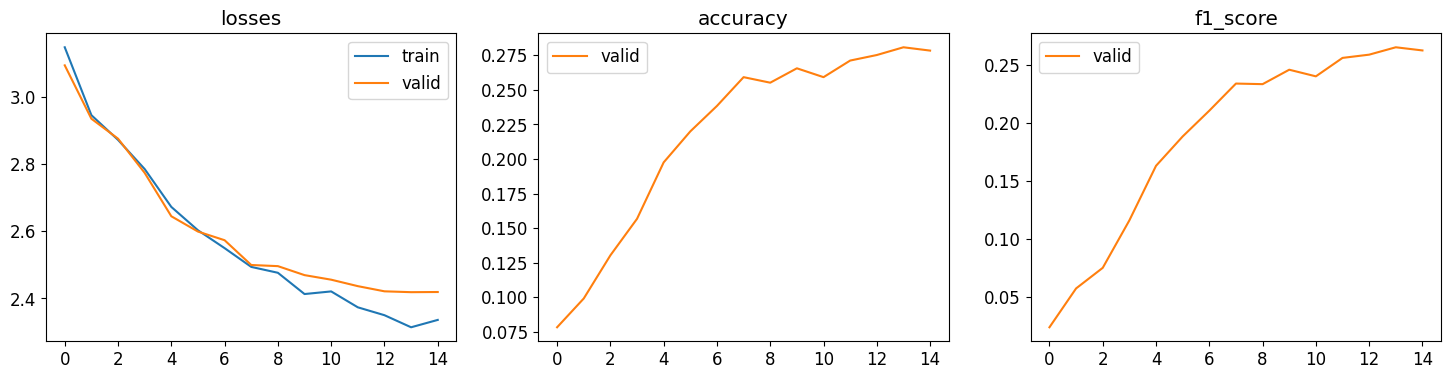


ACCURACY en el conjunto de ENTRENAMIENTO:  30.5067 %



ACCURACY en el conjunto de VALIDACIÓN:  27.84 %


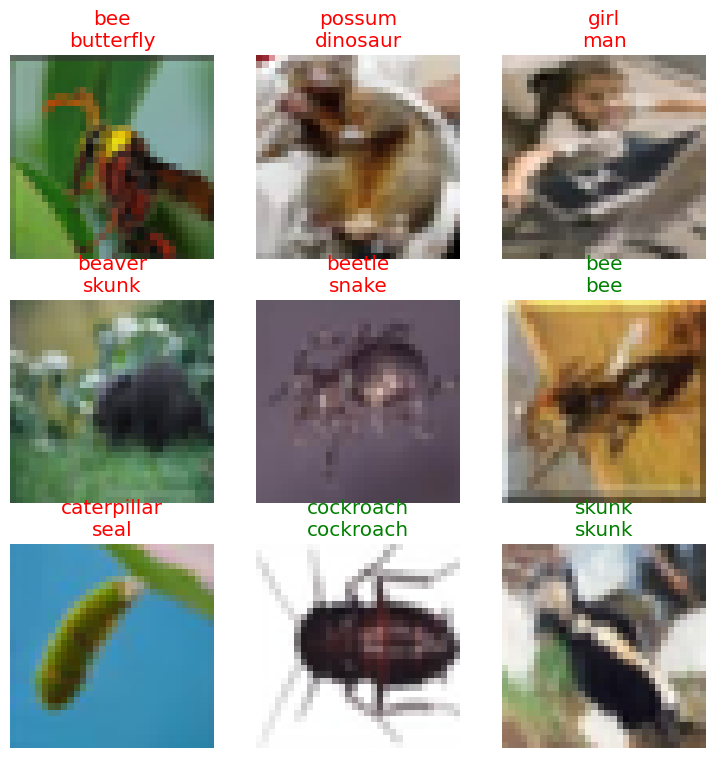

In [30]:
results(learn3, dls3)

27.84%, no se nota una mejora considerable, pero sabemos que en general es mejor usar ``ReLU`s. A partir de ahora usaremos solo esta función de activación.

## <font color='blue'> **2.4 Tamaño de los kernels**

Se conoce que en la práctica es mejor usar kernels más chicos, como $3 \times 3$, en vez de $9\times9$ o $7\times7$. De hecho un stack de $3$ capas con kernels $3\times3$ tiene el mismo campo receptivo que un kernel $7\times7$, con la ventaja de tener menos parámetros, y capturar una jerarquía de características más rica, algo que se usa en arquitecturas como VGGNet. Por lo tanto, vamos a cambiar los tamaños de los kernels en las capas convolucionales a $3\times3$, modificando también el input de la primera capa densa, ya que esta depende de las anteriores. La salida de la primera capa convolucional sería $30 \times 30$, tras maxpooling $15 \times 15$ y tras la segunda capa convolucional $13\times13$, luego teniendo en cuenta el número de canales la capa densa recibirá $13\times13\times10=1690$ entradas.

In [31]:
# BaseNet
BaseNet4 = sequential(
    nn.Conv2d(in_channels = 3, out_channels = 5, kernel_size = (3,3)),  # Capa 1: Convolución
    nn.Sigmoid(),                                                       # Capa 2: Sigmoide
    nn.MaxPool2d(kernel_size = (2,2)),                                  # Capa 3: MaxPooling2D
    nn.Conv2d(in_channels = 5, out_channels = 10, kernel_size = (3,3)), # Capa 4: Convolución
    nn.Tanh(),                                                          # Capa 5: Tanh
    nn.Flatten(),                                                       # Capa 6: Flatten
    nn.Linear(in_features = 1690, out_features = 50),                   # Capa 7: Fully-Connected
    nn.ReLU(),                                                          # Capa 8: ReLU
    nn.Linear(in_features = 50, out_features = 25)                      # Capa 9: Fully-Connected
    # nn.Softmax()
)

BaseNet4

Sequential(
  (0): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1))
  (1): Sigmoid()
  (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1))
  (4): Tanh()
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=1690, out_features=50, bias=True)
  (7): ReLU()
  (8): Linear(in_features=50, out_features=25, bias=True)
)

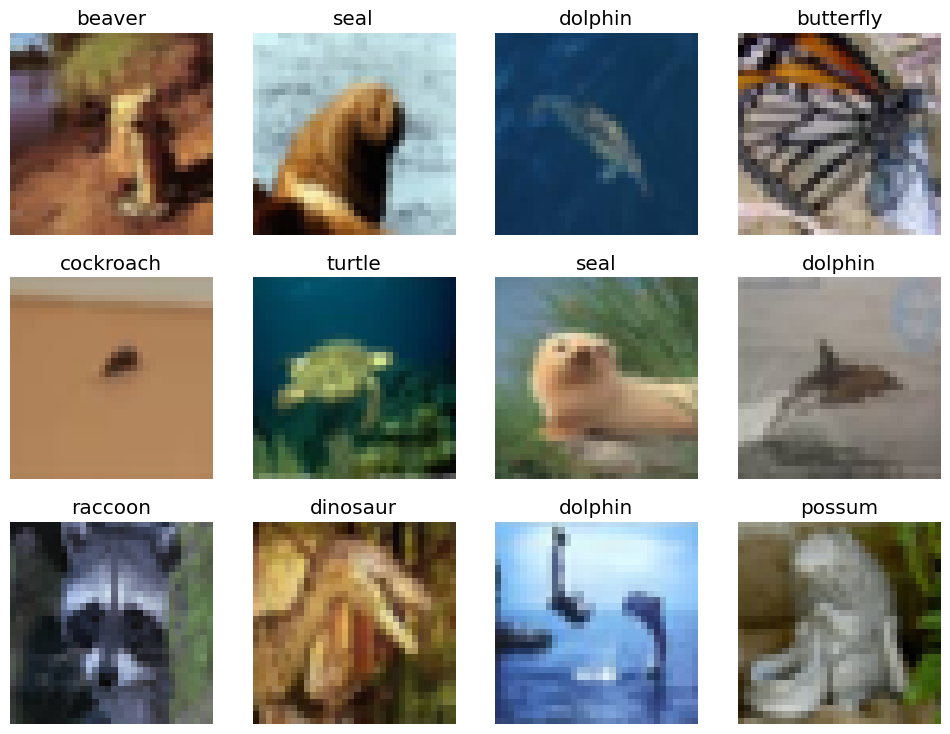

In [32]:
# Datablock
db4 = DataBlock(
  blocks    = (ImageBlock, CategoryBlock),                  # Tipos de datos de entrada y salida
  get_items = get_image_files,                              # Extraer imágenes
  splitter  = RandomSplitter(valid_pct = 0.1, seed = 42),   # Entrenamiento y validación (90%/10%)
  get_y     = parent_label                                 # Etiquetas
)

# Dataloader del conjunto de entrenamiento
dls4 = db4.dataloaders(path/'train', bs = 32)
# Imprimir un batch, con no más de 12 ejemplos
dls4.show_batch(max_n=12)

In [33]:
# Learner
learn4 = Learner(dls4, BaseNet4, loss_func = CrossEntropyLossFlat(), metrics = [accuracy, F1Score(average='weighted')])
learn4.summary()

Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 5 x 30 x 30    
Conv2d                                    140        True      
Sigmoid                                                        
____________________________________________________________________________
                     32 x 5 x 15 x 15    
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 10 x 13 x 13   
Conv2d                                    460        True      
Tanh                                                           
____________________________________________________________________________
                     32 x 1690           
Flatten                                                        
____________________________________________________________________________
                     32 x 50     

In [34]:
# Entrenamiento
cbs=[EarlyStoppingCallback(min_delta=0.01, patience=5)]
learn4.fit_one_cycle(n_epoch = 15, cbs=cbs)

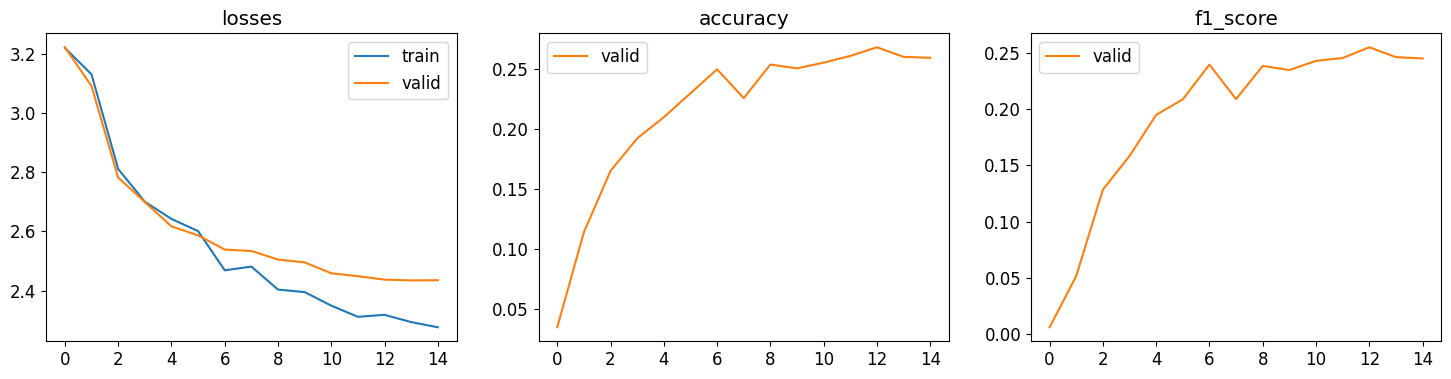


ACCURACY en el conjunto de ENTRENAMIENTO:  30.4622 %



ACCURACY en el conjunto de VALIDACIÓN:  25.92 %


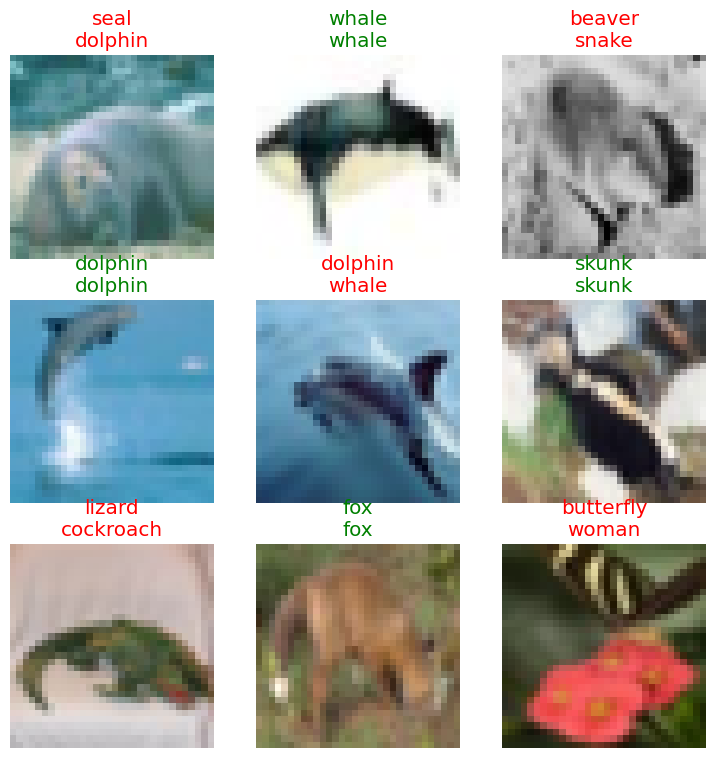

In [35]:
results(learn4, dls4)

El modelo ha empeorado con un 25.92%, es normal, la mejora de usar kernels más pequeño se verá cuando los concatenemos y usemos una arquitectura más profunda. A partir de ahora usamos kernels $3\times3$.

## <font color='blue'> **2.5 Profundidad del modelo**

Es un resultado conocido que un modelo más profundo suele aprender más y mejor (de allí aprendizaje profundo), por eso vamos a añadir capas al modelo. Lo esctructuraremos en bloques, cada bloque con capas convolucionales ($2$ en nuestro caso), funciones de activación `ReLU` y maxpooling. Esta estructura de bloques empíricamente se ha demostrado que es muy útil, nos permite construir el modelo como un juguete Lego, añadiendo y quitando bloques parecidos, de modo que varía la complejidad de la arquitectura. Nosotros nos limitaremos a $3$ bloques de este tipo, con un global average pooling al final, y una cabecera de dos capas densas, que es una cabecera bastante estándar. En las capas convolucionales añadimos padding para mantener dimensionalidad, y reduciremos solo con pooling. Otra cosa que hay que tener en cuenta es el número de canales. En general es aconsejable que `out_channels` sea una potencia de $2$, ya que se alinea con la memoria de GPU, y que a medida que añadimos capas se duplique el número de canales. Esta es una heurística buena porque las capas al principio aprenden patrones simples y tienen suficiente con un menor número de canales, mientras que capas posteriores aprenden características más complicadas y jerárquicas. Por eso el número de canales en nuestros bloques es $64$, $128$ y $256$. Como hacemos global average pooling, la primera capa densa recibe $256$ entradas.

In [36]:
# BaseNet
BaseNet5 = sequential(
    # Bloque 1
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),  # Pooling

    # Bloque 2
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),

    # Bloque 3
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1),
    nn.ReLU(),
    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),

    nn.AdaptiveAvgPool2d(output_size=(1, 1)),  # Global average pooling
    nn.Flatten(),  # Flattening

    # Capas densas
    nn.Linear(in_features=256, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=25),  # Salida
)
BaseNet5

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (15): AdaptiveAvgPool2d(output_size=(1, 1))
  (16): Flatten(start_dim=1, end_dim=-1)
  (17): Linear(in_features=256, out_features=128, bias=True)
  (18): ReLU()
  (19): Linear(i

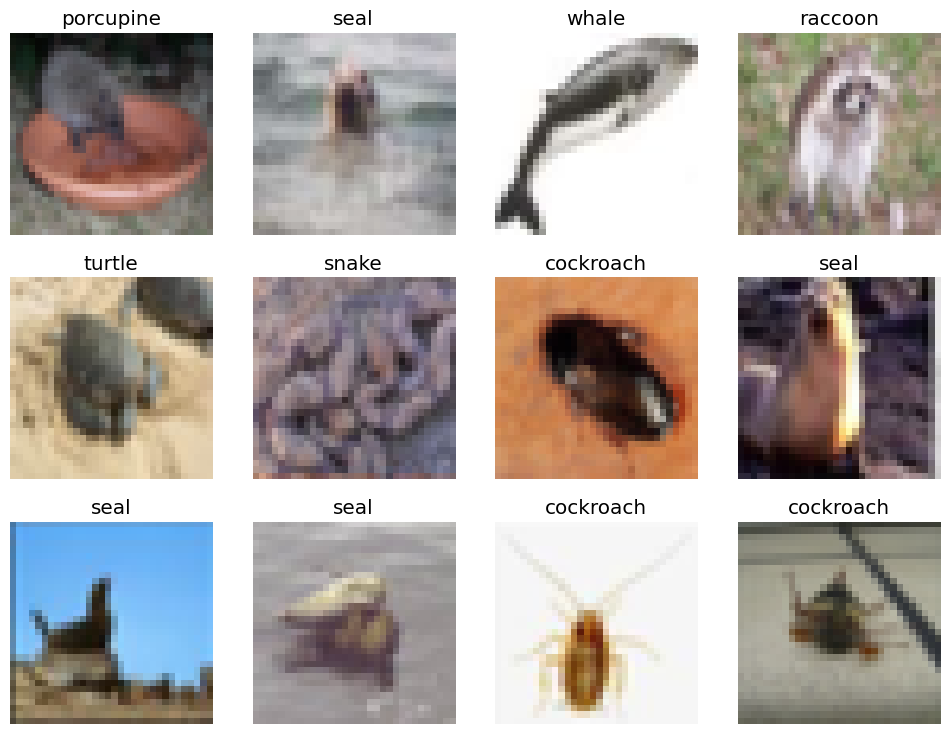

In [37]:
# Datablock
db5 = DataBlock(
  blocks    = (ImageBlock, CategoryBlock),                  # Tipos de datos de entrada y salida
  get_items = get_image_files,                              # Extraer imágenes
  splitter  = RandomSplitter(valid_pct = 0.1, seed = 42),   # Entrenamiento y validación (90%/10%)
  get_y     = parent_label                                 # Etiquetas
)

# Dataloader del conjunto de entrenamiento
dls5 = db5.dataloaders(path/'train', bs = 32)
# Imprimir un batch, con no más de 12 ejemplos
dls5.show_batch(max_n=12)

In [38]:
# Learner
learn5 = Learner(dls5, BaseNet5, loss_func = CrossEntropyLossFlat(), metrics = [accuracy, F1Score(average='weighted')])
learn5.summary()

Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 32 x 32   
Conv2d                                    1792       True      
ReLU                                                           
Conv2d                                    36928      True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 16 x 16   
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 128 x 16 x 16  
Conv2d                                    73856      True      
ReLU                                                           
Conv2d                                    147584     True      
ReLU                                                           
_____________________________________

In [39]:
# Entrenamiento
cbs=[EarlyStoppingCallback(min_delta=0.01, patience=5)]
learn5.fit_one_cycle(n_epoch = 15, cbs=cbs)

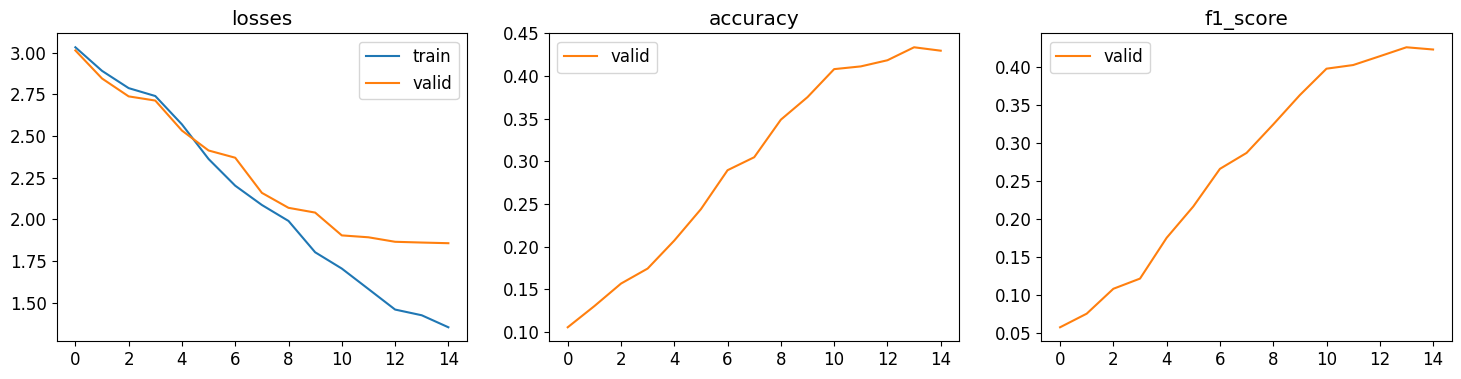


ACCURACY en el conjunto de ENTRENAMIENTO:  55.2178 %



ACCURACY en el conjunto de VALIDACIÓN:  42.96 %


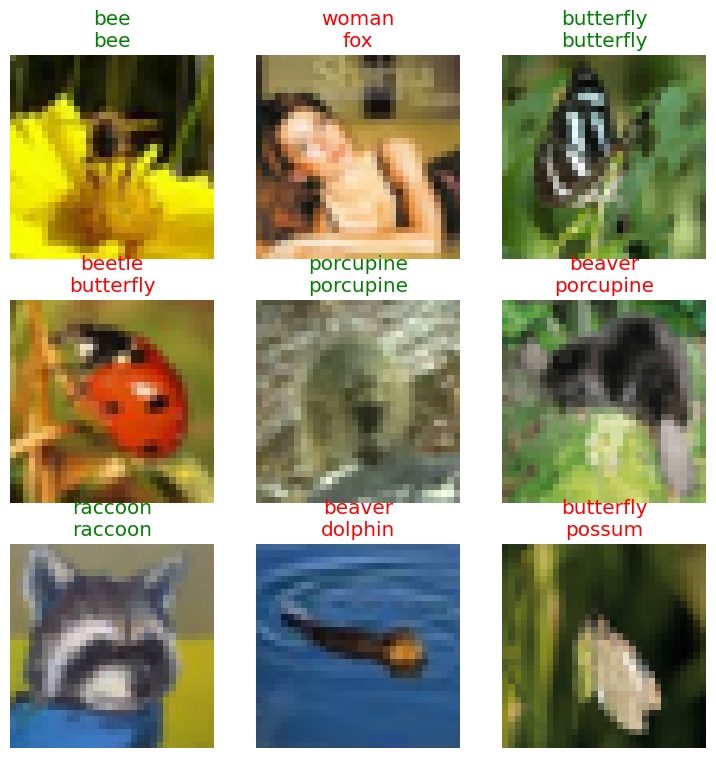

In [40]:
results(learn5, dls5)

Con un 42.96% hemos hecho una mejora considerable frente al 27.84% del modelo base. Eso era esperable, ya que una arquitectura más profunda es capaz de aprender patrones más difíciles. En el modelo final quizá añadamos un bloque más.

## <font color='blue'> **2.6 Batch Normalization**

Sabemos que normalizar inputs suele acelerar el entrenamiento, la idea de batch normalization es normalizar las entradas de las capas ocultas, normalmente antes de las funciones de activación. Consiste en normalizar los datos de un batch con la media y varianza del batch, y luego aplicar escalado con traslación, donde aparecen dos parámetros entrenables (por cada canal). Batch normalization ayuda evitar gradientes desvanecientes, acelera el entrenamiento y mejora la generalización. Aunque hay mucha polémica alrededor de si se debería hacer antes o después de la función de activación, por defecto se considera que es mejor antes. Nosotros probaremos solo con batchnorm antes de las funciones de activación.

In [41]:
BaseNet6 = sequential(
    # Bloque 1
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),  # Pooling

    # Bloque 2
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),

    # Bloque 3
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),

    nn.AdaptiveAvgPool2d(output_size=(1, 1)),  # Global average pooling
    nn.Flatten(),  # Flattening

    # Capas densas
    nn.Linear(in_features=256, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=25),  # Salida
)

BaseNet6

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU()
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256,

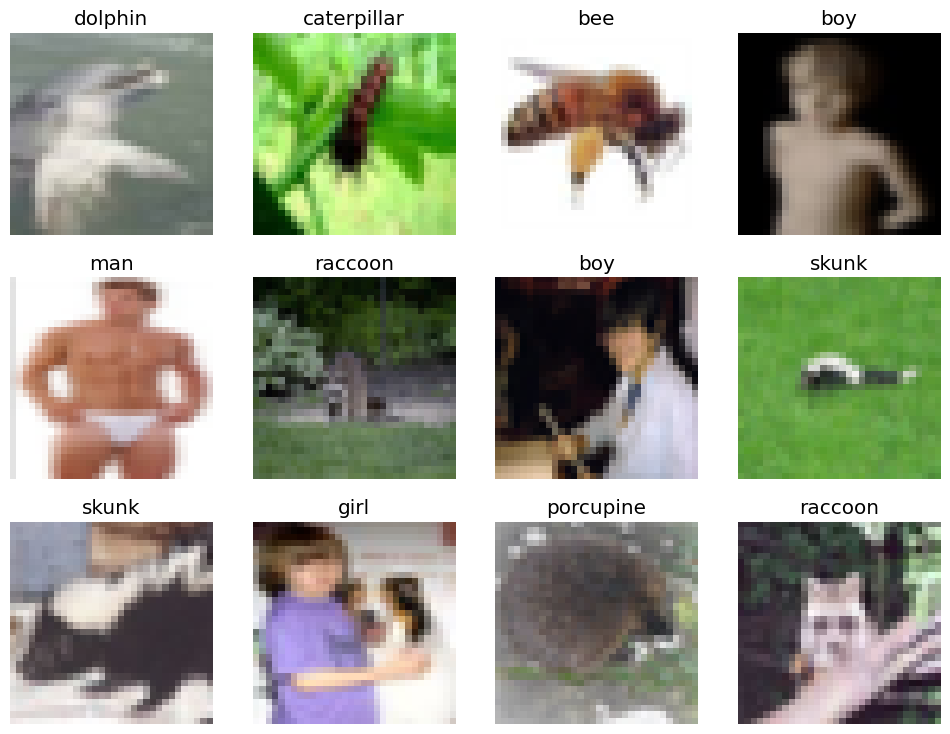

In [42]:
# Datablock
db6 = DataBlock(
  blocks    = (ImageBlock, CategoryBlock),                  # Tipos de datos de entrada y salida
  get_items = get_image_files,                              # Extraer imágenes
  splitter  = RandomSplitter(valid_pct = 0.1, seed = 42),   # Entrenamiento y validación (90%/10%)
  get_y     = parent_label                                 # Etiquetas
)

# Dataloader del conjunto de entrenamiento
dls6 = db6.dataloaders(path/'train', bs = 32)
# Imprimir un batch, con no más de 12 ejemplos
dls6.show_batch(max_n=12)

In [43]:
# Learner
learn6 = Learner(dls6, BaseNet6, loss_func = CrossEntropyLossFlat(), metrics = [accuracy, F1Score(average='weighted')])
learn6.summary()

Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 32 x 32   
Conv2d                                    1792       True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36928      True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 16 x 16   
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 128 x 16 x 16  
Conv2d                                    73856      True      
BatchNorm2d                               256        True      
ReLU                                 

In [44]:
# Entrenamiento
cbs=[EarlyStoppingCallback(min_delta=0.01, patience=5)]
learn6.fit_one_cycle(n_epoch = 15, cbs=cbs)

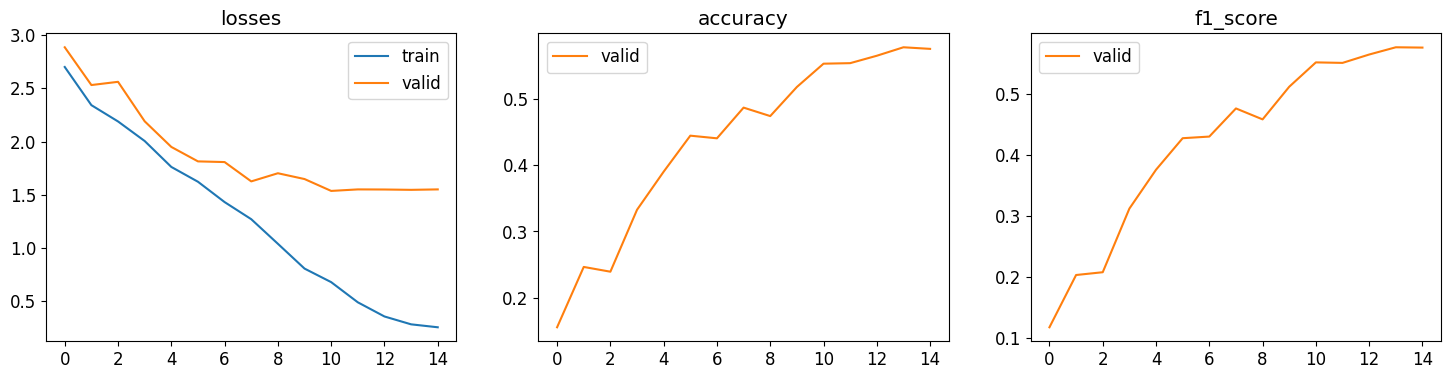


ACCURACY en el conjunto de ENTRENAMIENTO:  95.2356 %



ACCURACY en el conjunto de VALIDACIÓN:  57.6 %


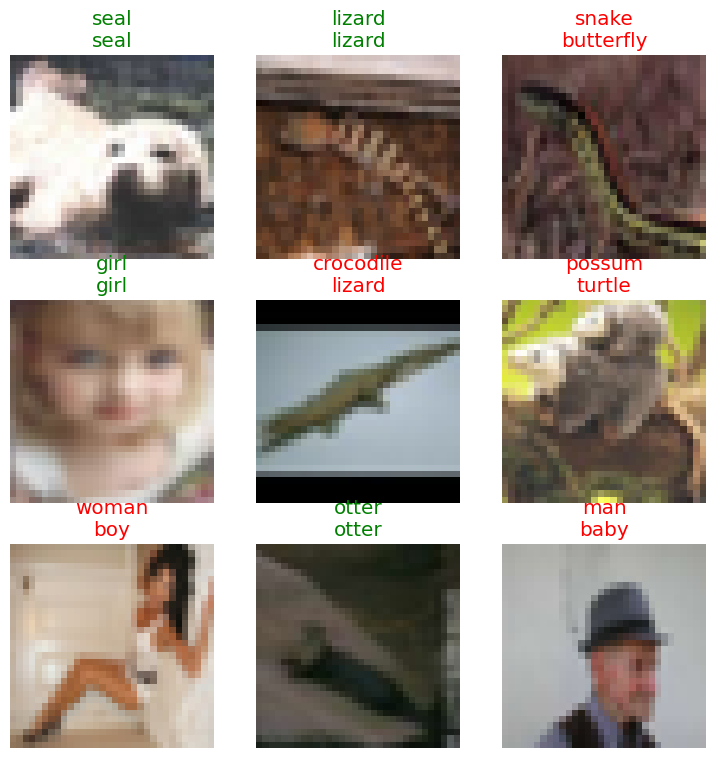

In [45]:
results(learn6, dls6)

Con batch normalization damos un salto más, a 57.6%, aunque se ve mucho overfitting. Aunque en general está muy bien, hace falta regularizar más. Usaremos batch normalization a partir de ahora.

## <font color='blue'> **2.7 Dropout**

Dropout es una técnica potente para mejorar la generalización, consiste en apagar neuronas con una probabilidad fijada por un hiperparámetro, de modo que durante la iteración esas neuronas no aprendan ni contribuyan. Esto hace que las neuronas sean más independientes y no haya tanto overfitting. En general, se suele usar después de capas densas o convolucionales en algunos casos. Nosotros usamos Dropout al final de las convolucionales y después de la primera capa densa.

In [46]:
BaseNet7 = sequential(
    # Bloque 1
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),  # Pooling

    # Bloque 2
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),

    # Bloque 3
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),

    nn.Dropout(0.4),  # Dropout

    nn.AdaptiveAvgPool2d(output_size=(1, 1)),  # Global average pooling
    nn.Flatten(),  # Flattening

    # Capas densas
    nn.Linear(in_features=256, out_features=128),
    nn.ReLU(),
    nn.Dropout(0.5),  # Dropout
    nn.Linear(in_features=128, out_features=25),  # Salida
)

BaseNet7

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU()
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256,

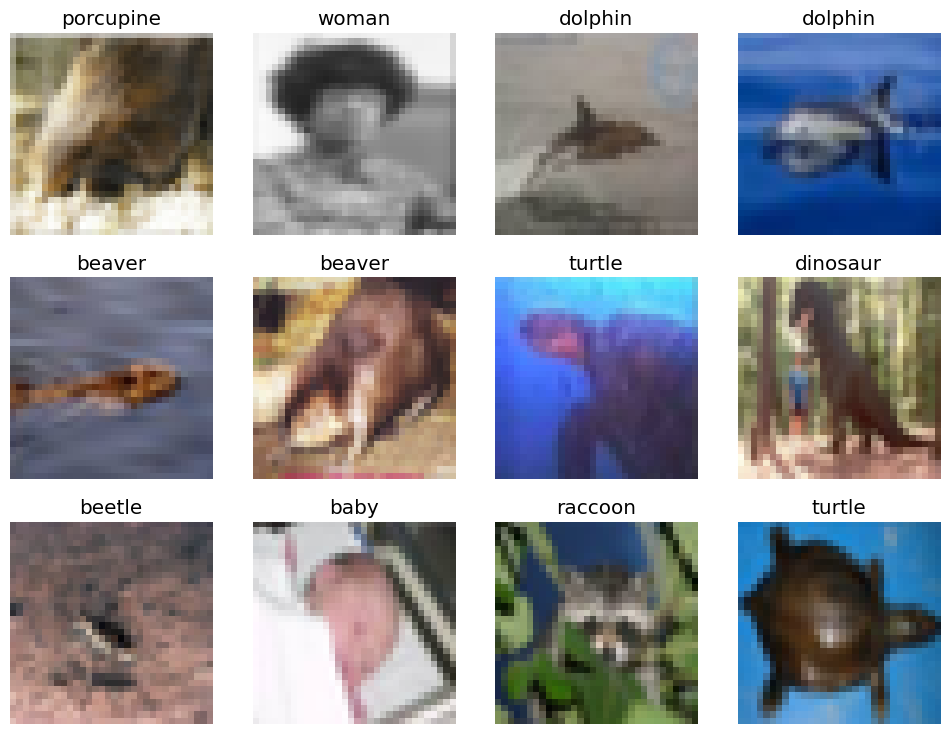

In [47]:
# Datablock
db7 = DataBlock(
  blocks    = (ImageBlock, CategoryBlock),                  # Tipos de datos de entrada y salida
  get_items = get_image_files,                              # Extraer imágenes
  splitter  = RandomSplitter(valid_pct = 0.1, seed = 42),   # Entrenamiento y validación (90%/10%)
  get_y     = parent_label                                 # Etiquetas
)

# Dataloader del conjunto de entrenamiento
dls7 = db7.dataloaders(path/'train', bs = 32)
# Imprimir un batch, con no más de 12 ejemplos
dls7.show_batch(max_n=12)

In [48]:
# Learner
learn7 = Learner(dls7, BaseNet7, loss_func = CrossEntropyLossFlat(), metrics = [accuracy, F1Score(average='weighted')])
learn7.summary()

Sequential (Input shape: 32 x 3 x 32 x 32)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 32 x 32   
Conv2d                                    1792       True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36928      True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 16 x 16   
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 128 x 16 x 16  
Conv2d                                    73856      True      
BatchNorm2d                               256        True      
ReLU                                 

In [49]:
# Entrenamiento
cbs=[EarlyStoppingCallback(min_delta=0.01, patience=5)]
learn7.fit_one_cycle(n_epoch = 15, cbs=cbs)

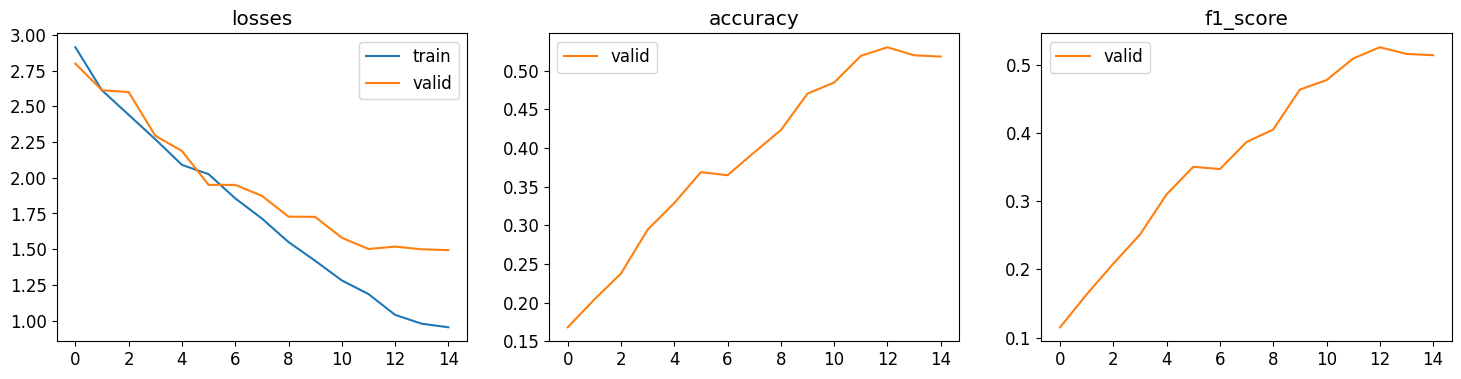


ACCURACY en el conjunto de ENTRENAMIENTO:  74.6489 %



ACCURACY en el conjunto de VALIDACIÓN:  51.84 %


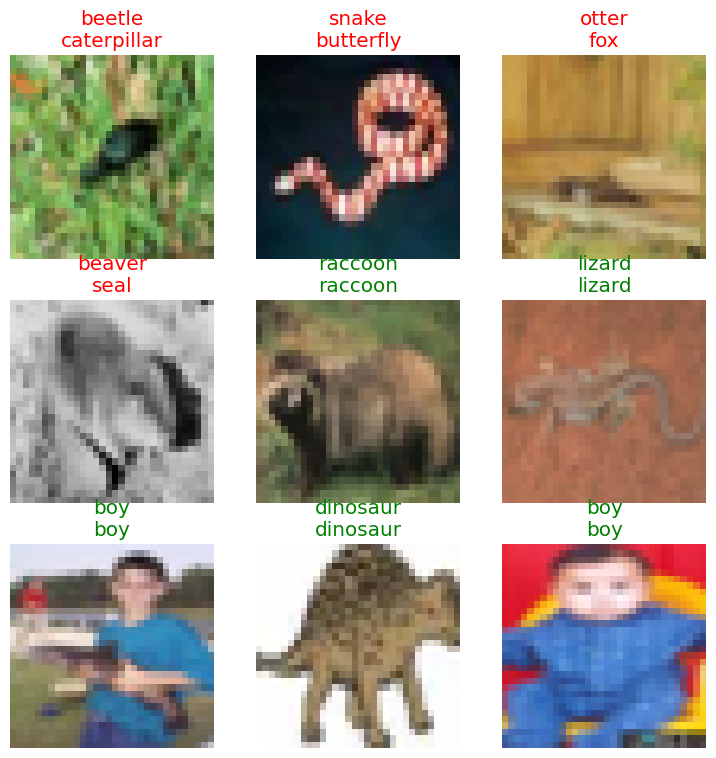

In [50]:
results(learn7, dls7)

Parece que ha empeorado algo el modelo en comparación con el apartado anterior, pero hay menos overfitting. En el modelo final usaremos dropout ya que nos hace falta más regularización.

## <font color='blue'> **2.8 Modelo final**

En el modelo final, combinamos todas las mejoras que hemos visto hasta ahora. En el `DataBlock` haremos normalización y data augmentation en `batch_tfms`, y en `item_tfms` haremos resize para hacer upsampling de nuestras imagenes $32 \times32$ a $64 \times64$. Hago esto porque pretendo añadir un bloque más y hacer un modelo más profundo. Como nuestras imágenes de entrada ya de por sí son bastante pequeñas, hago upsampling para que no "desaparezcan" las imágenes a medida que vamos subiendo en las capas.

Numero de ejemplos de entrenamiento (una vez descartados los de validacion): 11250
Numero de ejemplos de validacion: 1250


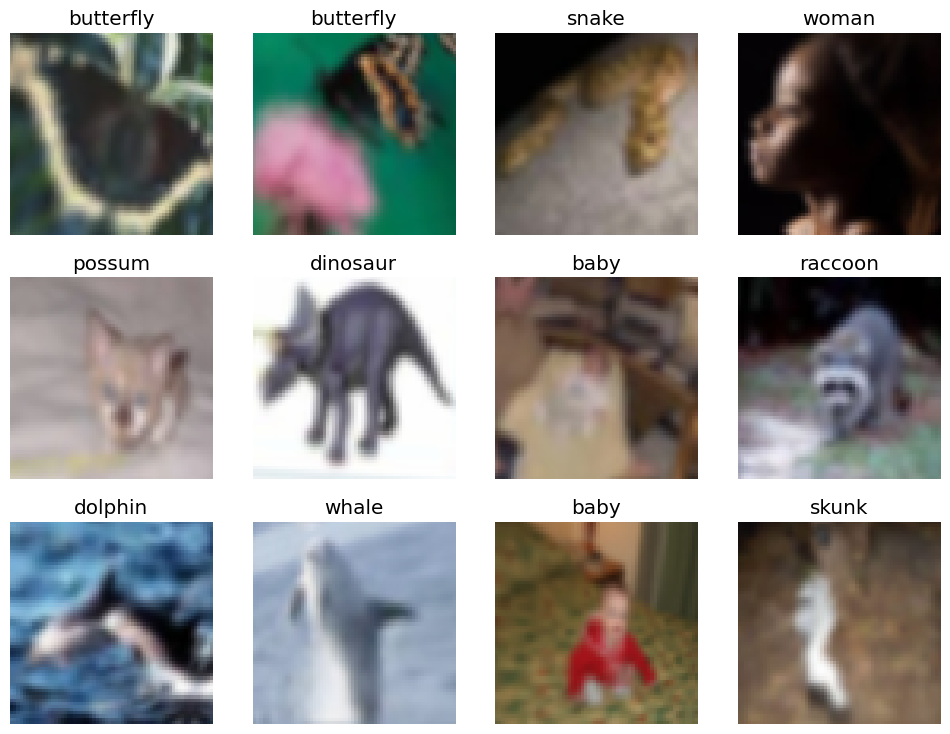

In [111]:
# Datablock
db = DataBlock(
  blocks    = (ImageBlock, CategoryBlock),                  # Tipos de datos de entrada y salida
  get_items = get_image_files,                              # Extraer imágenes
  splitter  = RandomSplitter(valid_pct = 0.1, seed = 42),   # Entrenamiento y validación (90%/10%)
  get_y     = parent_label,                                 # Etiquetas
  item_tfms  = Resize(64),
  batch_tfms = [Normalize.from_stats(*cifar_stats), *aug_transforms()]
)

# Dataloader del conjunto de entrenamiento
dls = db.dataloaders(path/'train', bs = 32)
# Imprimir un batch, con no más de 12 ejemplos
dls.show_batch(max_n=12)

print('Numero de ejemplos de entrenamiento (una vez descartados los de validacion):', len(dls.train_ds))
print('Numero de ejemplos de validacion:', len(dls.valid_ds))

Example of training data


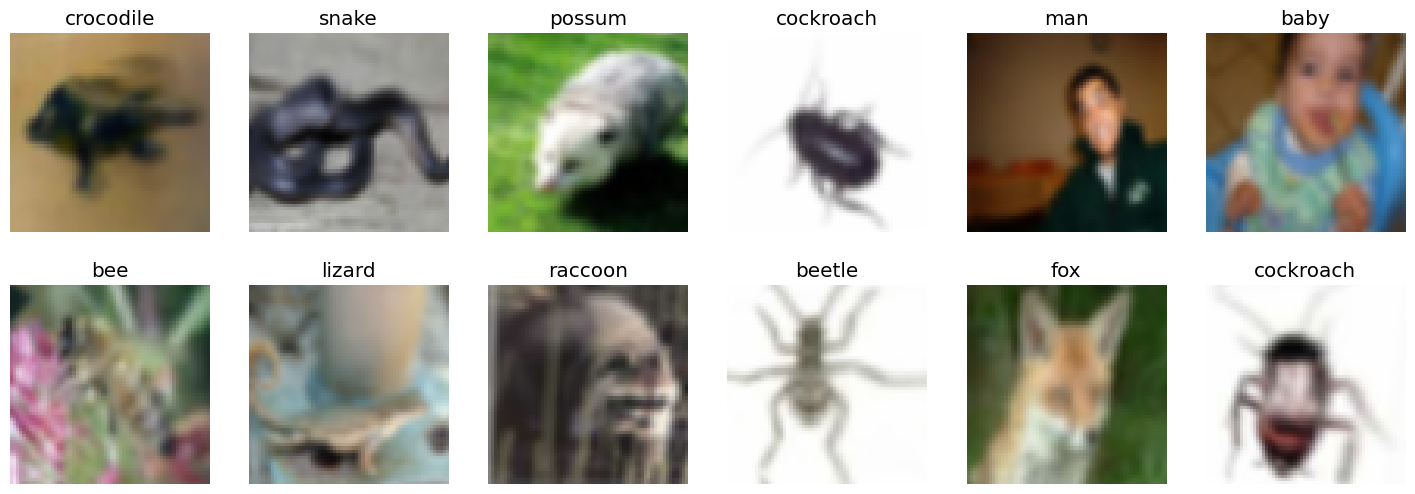

In [112]:
print('Example of training data')
dls.train.show_batch(max_n=12, nrows=2)

Example of validation data


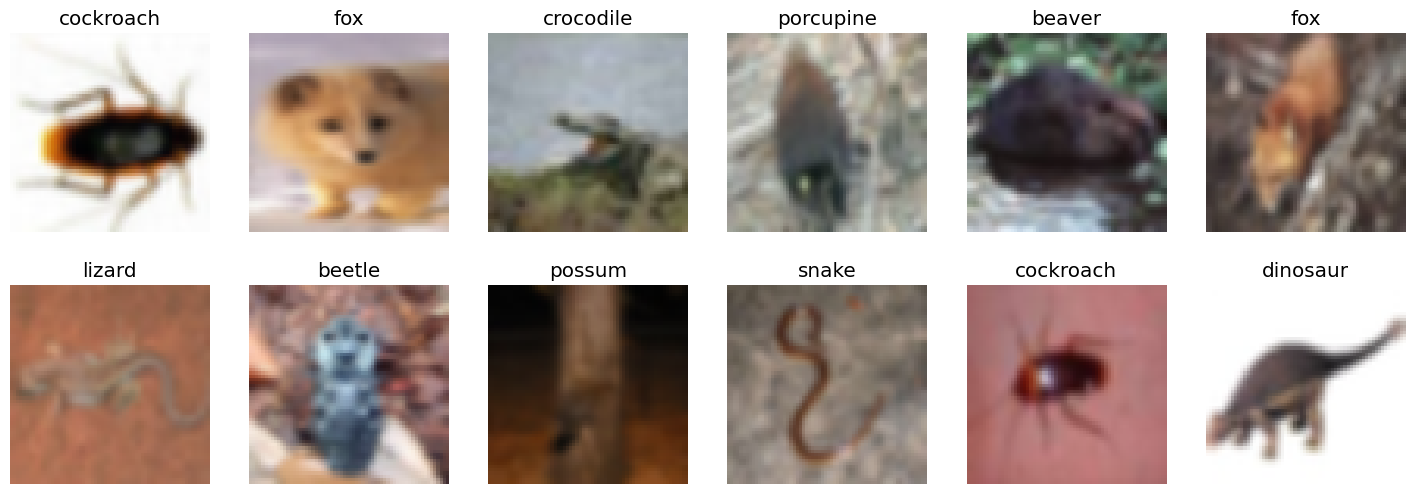

In [113]:
print('Example of validation data')
dls.valid.show_batch(max_n=12, nrows=2)

En el modelo como ya hemos dicho añadiremos un cuarto bloque. Además he quitado el dropout al final de las convolucionales y he añadido un batch normalization después de la primera capa densa. Esto debería mejorar el modelo. También he quitato global average pooling porque pensaba que me empeoraba el accuracy.

In [114]:
BaseNet = sequential(
    # Bloque 1
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),  # Output: (64 / 2 = 32) x 32 x 64

    # Bloque 2
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),  # Output: (32 / 2 = 16) x 16 x 128

    # Bloque 3
    nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),  # Output: (16 / 2 = 8) x 8 x 256

    # Bloque 4
    nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1),
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)),

    nn.Flatten(),  # Flattening: 4 x 4 x 512 = 8192 salidas

    # Capas densas
    nn.Linear(in_features=8192, out_features=512),
    nn.BatchNorm1d(num_features=512),
    nn.ReLU(),
    nn.Dropout(0.4),  # Dropout
    nn.Linear(in_features=512, out_features=25),  # Salida
)

BaseNet

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU()
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256,

Igual que en el ejercicio 1, vamos a desglosar los parámetros que tiene el modelo. Para eso recordamos que BatchNorm son 2 parámetros por capa.

*   Conv2d: $(3\times3\times3+1)\times 64 = 1792$
*   BatchNorm2D: $64\times2=128$
*   ReLU: nada
*   Conv2d: $(3\times3\times64+1)\times 64 = 36928$
*   BatchNorm2D: $64\times2=128$
*   ReLU: nada
*   MaxPool2d: nada

*   Conv2d: $(3\times3\times64+1)\times 128 = 73856$
*   BatchNorm2D: $128\times2=256$
*   ReLU: nada
*   Conv2d: $(3\times3\times128+1)\times 128 = 147584$
*   BatchNorm2D: $128\times2=256$
*   ReLU: nada
*   MaxPool2d: nada

*   Conv2d: $(3\times3\times128+1)\times 256 = 295168$
*   BatchNorm2D: $256\times2=512$
*   ReLU: nada
*   Conv2d: $(3\times3\times256+1)\times 256 = 590080$
*   BatchNorm2D: $256\times2=512$
*   ReLU: nada
*   MaxPool2d: nada

*   Conv2d: $(3\times3\times256+1)\times 512 = 1180160$
*   BatchNorm2D: $512\times2=1024$
*   ReLU: nada
*   Conv2d: $(3\times3\times512+1)\times 512 = 2359808$
*   BatchNorm2D: $512\times2=1024$
*   ReLU: nada
*   MaxPool2d: nada

*   Flatten: nada
*   Linear: $ = 8192\times512 + 512 = 4194816$
*   BatchNorm1d: $512\times2=1024$
*   ReLU: nada
*   Dropout: nada
*   Linear: $512\times 25 +25 = 12825$

En total 8,897,881 parámetros. Como podemos ver abajo, efectívamente es así.

In [115]:
# Learner
learn = Learner(dls, BaseNet, loss_func = CrossEntropyLossFlat(), metrics = [accuracy, F1Score(average='weighted')])
learn.summary()

Sequential (Input shape: 32 x 3 x 64 x 64)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 64 x 64   
Conv2d                                    1792       True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36928      True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 32 x 32   
MaxPool2d                                                      
____________________________________________________________________________
                     32 x 128 x 32 x 32  
Conv2d                                    73856      True      
BatchNorm2d                               256        True      
ReLU                                 

Aprenderemos con el learning rate máximo del 1cycle fijado por el `lr_find`, que suele proporcionar valores sensatos. Nos interesa el rate más alto posible sin que sea demasiado grande como para divergir.

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

0.00013182566908653826


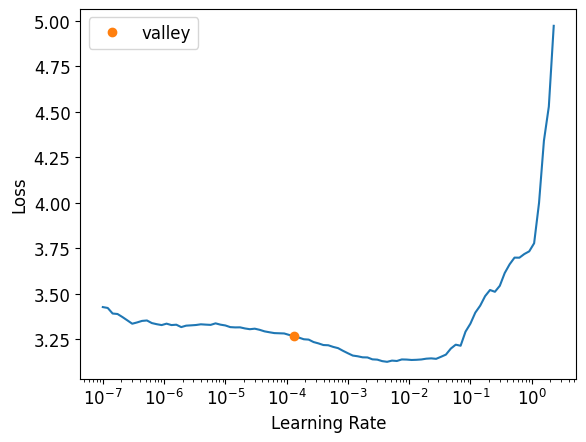

In [116]:
lr=learn.lr_find() # find the maximum value for lr to use in the next call to the optimizer
print(lr[0])

In [117]:
# Entrenamiento
cbs=[EarlyStoppingCallback(min_delta=0.01, patience=5)]
learn.fit_one_cycle(n_epoch = 20, cbs=cbs, lr_max=lr[0])

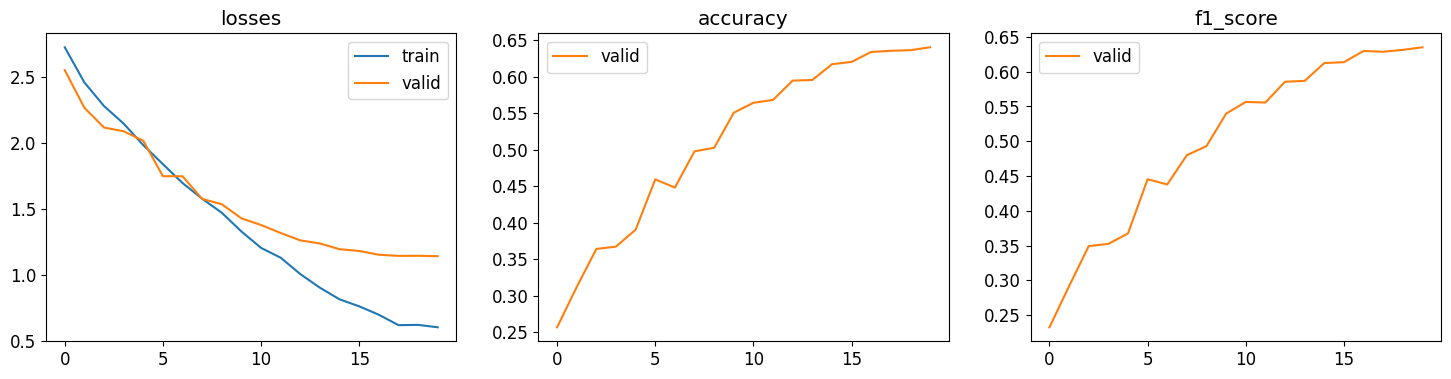


ACCURACY en el conjunto de ENTRENAMIENTO:  87.3422 %



ACCURACY en el conjunto de VALIDACIÓN:  64.0 %


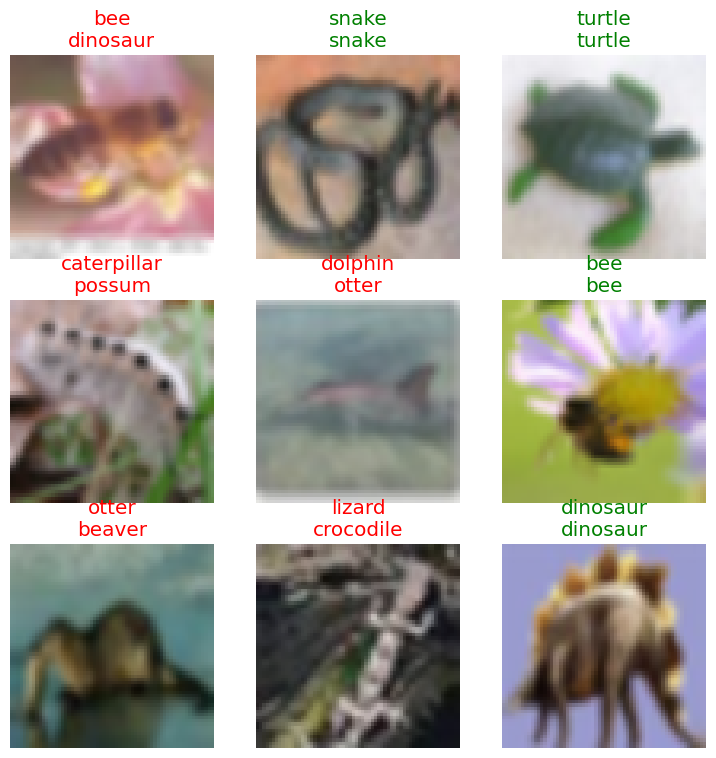

In [118]:
results(learn, dls)

Hemos obtenido un accuracy en validación de 64% y tenemos mucho overfitting. El modelo debería mejorarse más pero solo he podido llegar hasta aquí. Veamos el accuracy en test y las matrices de confusión en todos los conjuntos.

In [119]:
# Definición del dataloader para el conjunto de test
test_dl = learn.dls.test_dl(files_test, with_labels = True)

# Generación de predicciones del modelo entrenado en el conjunto de test
preds, targs, _ = learn.get_preds(dl = test_dl, with_decoded = True)

# Accuracy en el conjunto de test
test_acc = accuracy(preds, targs)
print('\nACCURACY en el conjunto TEST: ', round(float(test_acc) * 100, 4), '%')


ACCURACY en el conjunto TEST:  64.04 %


En test también tenemos 64%. Un resultado lejano de ser bueno pero tampoco extremadamente malo.

Number of training examples: 11250


Training Accuracy
87.1111111111111


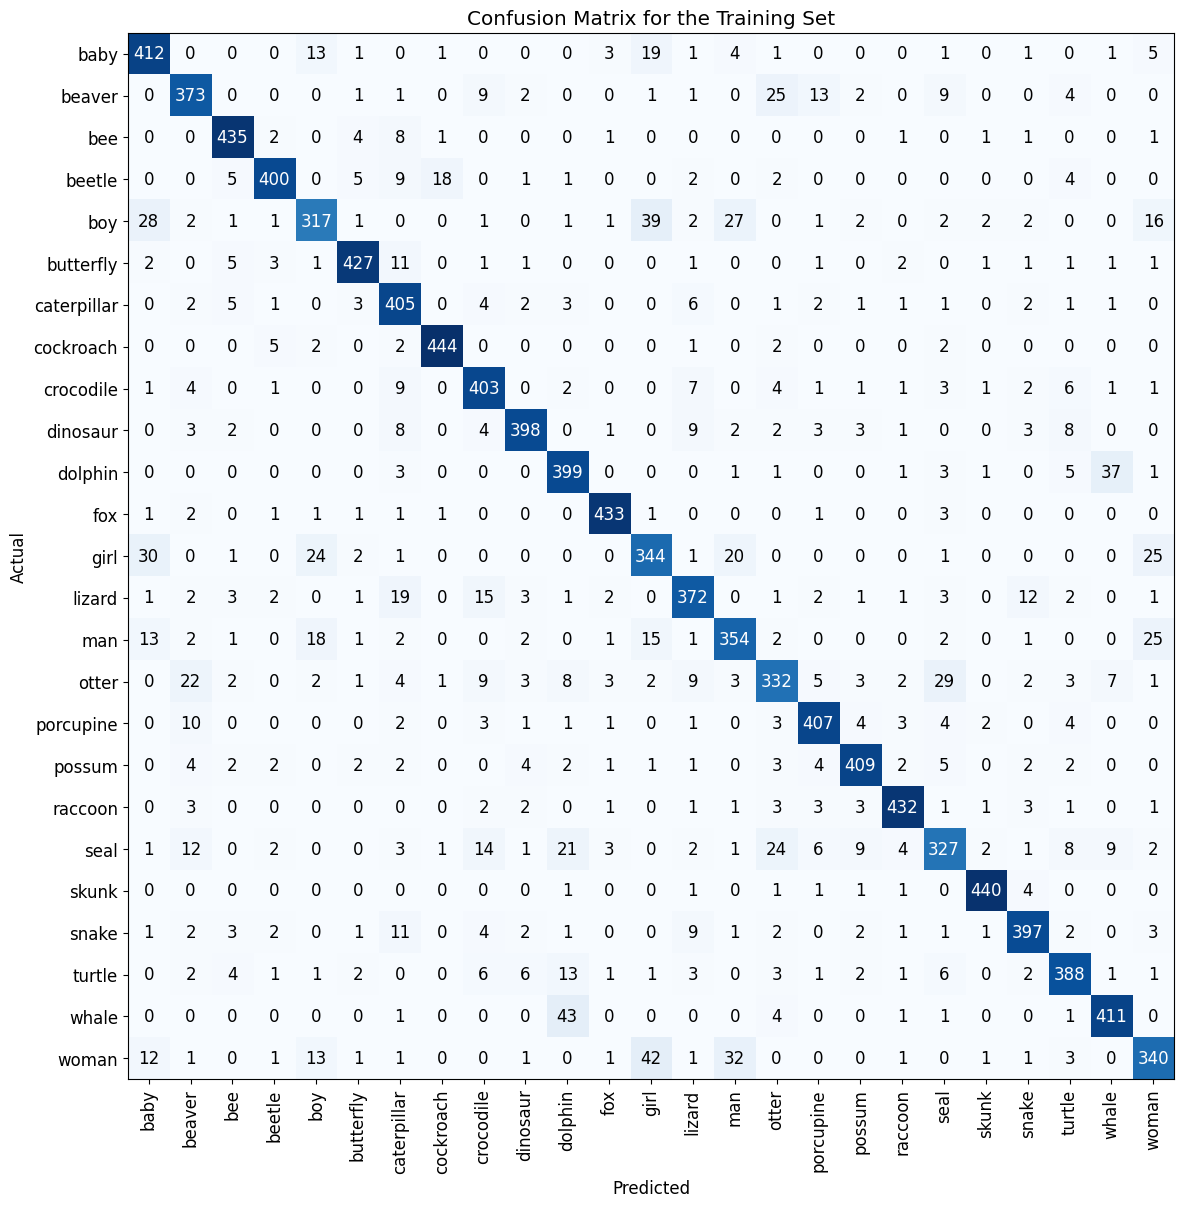

In [120]:
# Matriz de confusión
interp_train = ClassificationInterpretation.from_learner(learn, 1, dls.train)
cm_train = interp_train.confusion_matrix()
print('Number of training examples:', np.sum(cm_train))
interp_train.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Training Set')
print('Training Accuracy')
print(np.sum(np.diagonal(cm_train))/np.sum(cm_train)*100)

Number of validation examples: 1250


Validation Accuracy
64.0


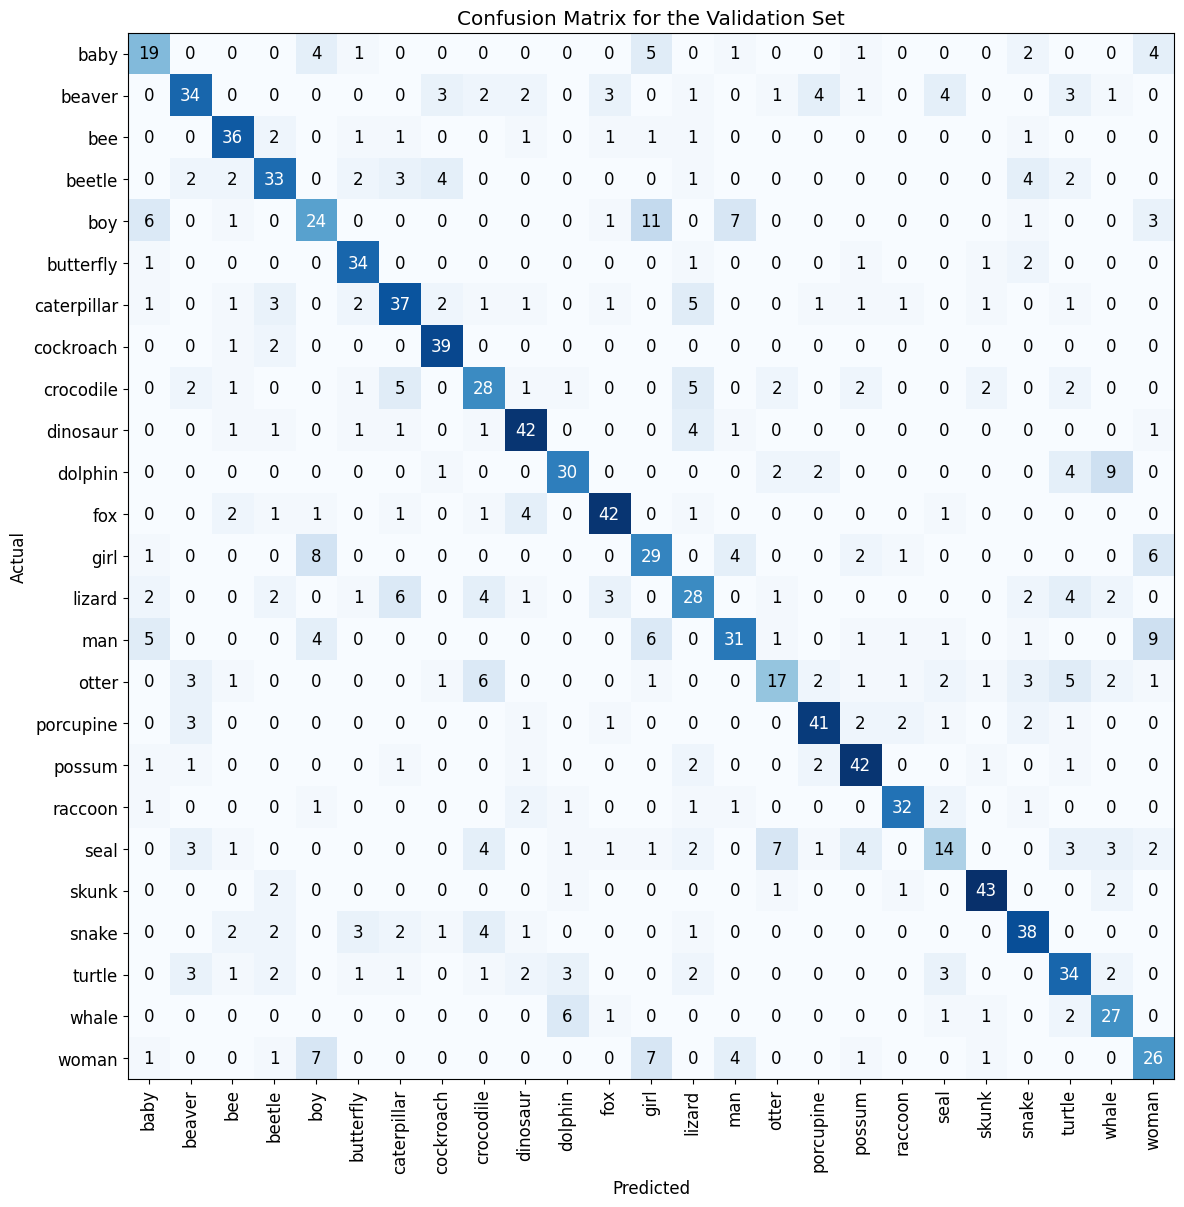

In [121]:
# Matriz de confusión
interp_valid = ClassificationInterpretation.from_learner(learn, 1, dls.valid)
cm_valid = interp_valid.confusion_matrix()
print('Number of validation examples:', np.sum(cm_valid))
interp_valid.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Validation Set')
print('Validation Accuracy')
print(np.sum(np.diagonal(cm_valid))/np.sum(cm_valid)*100)

Number of test examples: 2500


Test Accuracy
64.03999999999999


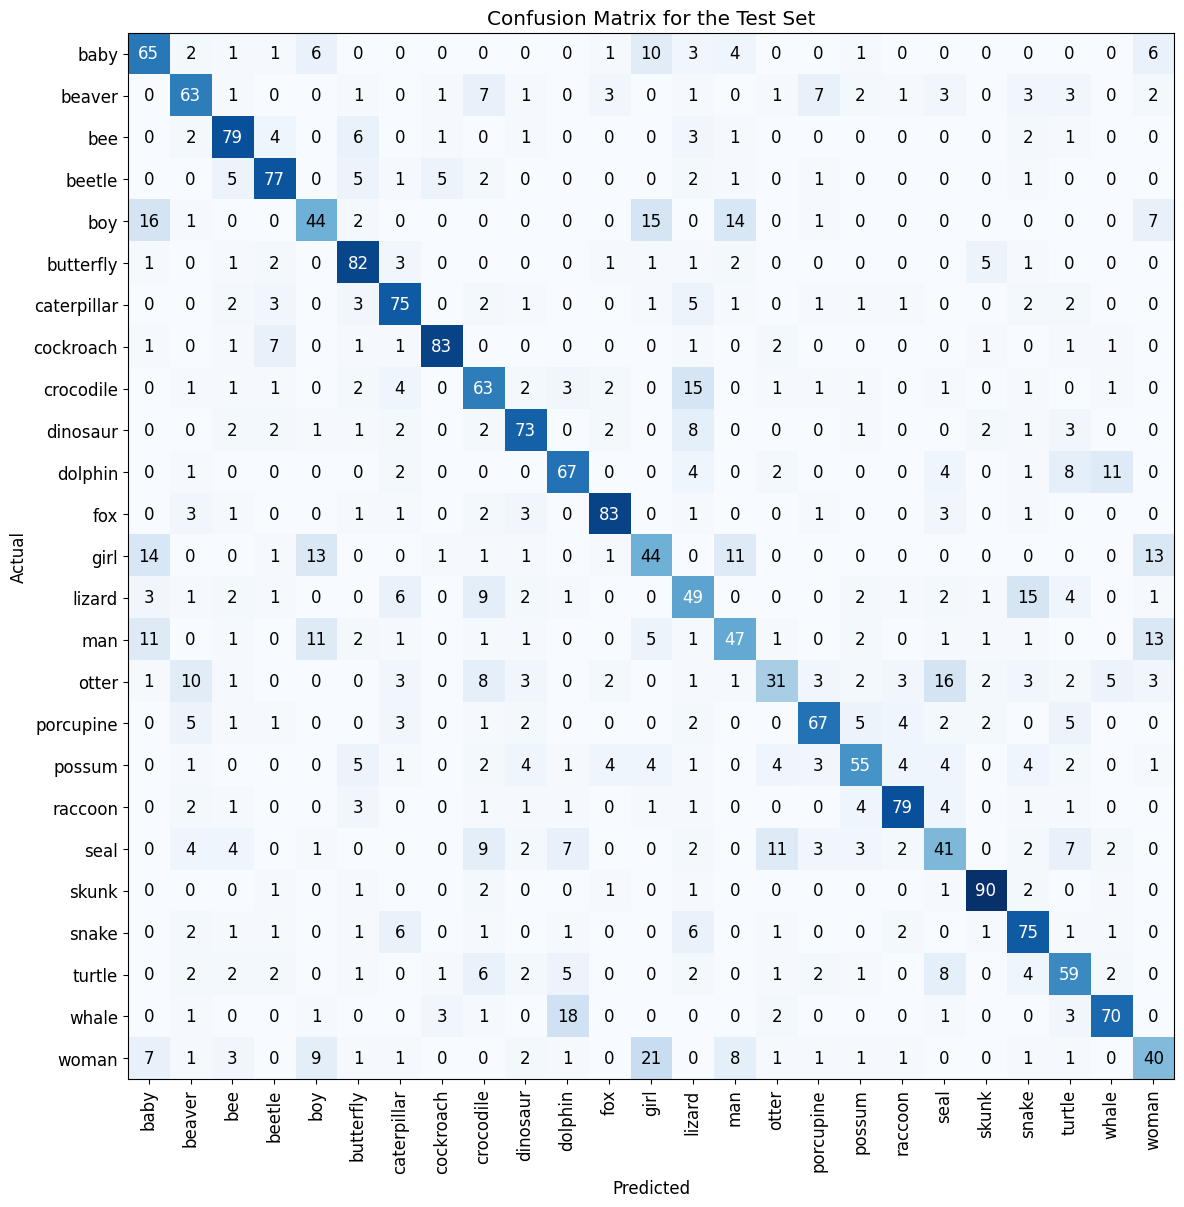

In [122]:
# Matriz de confusión
interp_test = ClassificationInterpretation.from_learner(learn, 1, test_dl)
cm_test = interp_test.confusion_matrix()
print('Number of test examples:', np.sum(cm_test))
interp_test.plot_confusion_matrix(figsize=(12, 12),title='Confusion Matrix for the Test Set')
print('Test Accuracy')
print(np.sum(np.diagonal(cm_test))/np.sum(cm_test)*100)

En las matrices de confusión observamos que el modelo sigue confundiendo muchas cosas, aunque suele confundir más cosas parecidas, como baby-girl-boy-man, dolphin-whale, lizard-snake-crocodile. Parece que no ha aprendido a distinguir muy bien cosas parecidas. Probablemente esto se resuelve con modelos más profundos, como podría ser una ResNet. Nosotros hemos conseguido que al menos no confunda mucho las cosas distintas.

## <font color='blue'> **2.9 Conclusiones**

Como conclusión, podría decirse que hemos mejorado el modelo base de 28% a 64%, una mejora de más del doble, pero que seguimos con un modelo no muy bueno. Deberíamos mejorarlo más, o algo que podría ser más fácil, inspirarnos en arquitecturas que ya se conoce que funcionan bien. Pero en este ejercicio he decidido probar cosas desde 0 sin copiar mucho arquitecturas populares, para aprender más. En el futuro, este modelo debería regularizarse más para evitar el grandísimo overfitting que tenemos.